Python Notebook for analyzing all real data results in the Phyllochron manuscript

In [315]:
import matplotlib.pyplot as plt
import pandas as pd
import pygraphviz as pgv
import networkx as nx
import numpy as np
from collections import defaultdict
import seaborn as sns
import scipy
from scipy.special import gammaln, logsumexp
import pickle
from networkx.drawing.nx_pydot import graphviz_layout


import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

In [316]:
def calculate_likelihood_rc(inferred, variant, total, prop):
    l = 0
    fp_error_rate = prop
    alpha = fp_error_rate * 15
    beta = (1-fp_error_rate) * 15
    for r in range(inferred.shape[0]):
        prof = np.zeros(inferred.shape[1])
        for c in range(inferred.shape[1]):
            if total[r,c] > 0.5:
                prof[c] = scipy.stats.betabinom.logpmf(variant[r,c], total[r,c], 1, 1) - scipy.stats.betabinom.logpmf(variant[r,c], total[r,c], alpha, beta)
        l += np.dot(prof, inferred[r])
    return l

In [317]:
def calculate_likelihood_rc_single(inferred, variant, total, prop):
    l = 0
    fp_error_rate = prop
    alpha = fp_error_rate * 15
    beta = (1-fp_error_rate) * 15
    for c in range(len(inferred)):
        if total[c] > 0.5 and inferred[c] > 0.5:
            l += scipy.stats.betabinom.logpmf(variant[c], total[c], 1, 1) - scipy.stats.betabinom.logpmf(variant[c], total[c], alpha, beta)
    return l

In [318]:
def compute_SNV_loglikelihoods(c_ref, c_alt, r, v, locus, dropout_rate_ref, dropout_rate_alt, sequencing_error_rate, n_cells):
    # If homozygous, the copy number of the only allele is irrelevant for the allelic proportion

    hash_key = c_ref + 20 * c_alt + 400 * locus

    discretized_dropout_rate_ref = round(dropout_rate_ref * 1000)
    discretized_dropout_rate_alt = round(dropout_rate_alt * 1000)
    hash_dropoutrates = discretized_dropout_rate_ref + 1000 * discretized_dropout_rate_alt
    

    dropout_rate_ref = discretized_dropout_rate_ref / 1000.0
    dropout_rate_alt = discretized_dropout_rate_alt / 1000.0

    likelihood_alleles_cells = [[] for _ in range((c_ref + 1) * (c_alt + 1) - 1)]
    dropoutscores = [0.0] * n_cells

    idx = 0
    for k in range(c_ref + 1):
        for l in range(c_alt + 1):
            if k == 0 and l == 0:
                continue
            
            hash_dropout = k + 20 * l + 400 * locus
            
            seq_error_rates = [0.0] * n_cells
            eps1 = sequencing_error_rate
            eps2 = sequencing_error_rate
            omega = 15 if k == 0 or l == 0 else 15
            

            f = (1.0 * l / (k + l)) * (1 - eps2) + (1.0 * k / (k + l)) * eps1

            for j in range(n_cells):
                ref_count = r
                alt_count = v
                likelihood_dropout = (gammaln(alt_count + omega * f) + 
                                      gammaln(ref_count + omega * (1 - f)) - 
                                      gammaln(alt_count + ref_count + omega) - 
                                      gammaln(omega * f) - 
                                      gammaln(omega * (1 - f)) + 
                                      gammaln(omega))
                dropoutscores[j] = likelihood_dropout


            likelihood_alleles_cells[idx] = [0.0] * n_cells
            dropout_prob = (log_n_choose_k(c_ref, k) + log_n_choose_k(c_alt, l) + 
                            (c_ref - k) * np.log(dropout_rate_ref) + 
                            k * np.log(1 - dropout_rate_ref) + 
                            (c_alt - l) * np.log(dropout_rate_alt) + 
                            l * np.log(1 - dropout_rate_alt))
            all_dropout_prob = (dropout_rate_ref ** c_ref) * (dropout_rate_alt ** c_alt)
            dropout_prob -= np.log(1 - all_dropout_prob)

            for j in range(n_cells):
                likelihood_alleles_cells[idx][j] = dropoutscores[j] + dropout_prob

            idx += 1

    scores_cells = logsumexp(likelihood_alleles_cells, axis=0)
    dropoutsref = [0.0] * n_cells
    dropoutsalt = [0.0] * n_cells

    idx = 0
    for k in range(c_ref + 1):
        for l in range(c_alt + 1):
            if k == 0 and l == 0:
                continue

            for j in range(n_cells):
                config_prob = np.exp(likelihood_alleles_cells[idx][j] - scores_cells[j])
                dropoutsref[j] += (c_ref - k) * config_prob
                dropoutsalt[j] += (c_alt - l) * config_prob

            idx += 1

    return scores_cells, dropoutsref, dropoutsalt

In [319]:
def log_n_choose_k(n, k):
    return gammaln(n + 1) - (gammaln(k + 1) + gammaln(n - k + 1))

In [320]:
def calculate_likelihood_COMPASS(inferred, variant, total, prop):
    l = 0
    fp_error_rate = prop
    alpha = fp_error_rate * 15
    beta = (1-fp_error_rate) * 15
    for r in range(inferred.shape[0]):
        for c in range(inferred.shape[1]):
            if inferred[r,c] > 0.5:
                l += compute_SNV_loglikelihoods(1, 1, total[r,c] - variant[r,c],  variant[r,c], c, 0.01, 0.01, prop, 1)[0][0]
            else:
                l += compute_SNV_loglikelihoods(2, 0, total[r,c] - variant[r,c],  variant[r,c], c, 0.01, 0.01, prop, 1)[0][0]
    return l



In [321]:
def calculate_likelihood_COMPASS_single(inferred, variant, total, prop):
    l = 0
    fp_error_rate = prop
    alpha = fp_error_rate * 15
    beta = (1-fp_error_rate) * 15
    for c in range(len(inferred)):
        if inferred[c] > 0.5:
            l += compute_SNV_loglikelihoods(1, 1, total[c] - variant[c],  variant[c], c, 0.01, 0.01, prop, 1)[0][0]
        else:
            l += compute_SNV_loglikelihoods(2, 0, total[c] - variant[c],  variant[c], c, 0.01, 0.01, prop, 1)[0][0]
    return l

In [322]:
def build_compass_matrix(cell_assignment, genotype_file, nmutations):
    mat = np.zeros((cell_assignment.shape[0], nmutations))
    profiles = genotype_file.values[:, 1:]
    for cell in range(cell_assignment.shape[0]):
        mat[cell] = profiles[cell_assignment['node'][cell]].astype(int)
    return mat

In [399]:
def analyze_SPhyR_results(patient_name, ntimepoints):
    with open(f"../data/AML/mutation_selection/{patient_name}_mutations.pkl", "rb") as f:
        patient_mutations = pickle.load(f)
        
    with open(f"../data/AML/mutation_selection/{patient_name}_annotations.pkl", "rb") as f:
        patient_annotations = pickle.load(f)
        
    with open(f"../data/AML/method_input/{patient_name}_data_size.pkl", "rb") as f:
        size = pickle.load(f)
        
    
    time_cells = defaultdict()
    df_sol = pd.read_csv(f'../data/AML/SPhyR/{patient_name}_sphyr.csv',sep=' ',skiprows=2, header=None)
    df_vals = df_sol.values
    nmutations = df_vals.shape[1]
    ncells = df_vals.shape[0]
    
    genotype_matrix = np.unique(df_vals, axis=0)
    
    
    COMPASS_cell_assignment = pd.read_csv(f'../data/AML/COMPASS/{patient_name}_cellAssignments.tsv', sep='\t')
    COMPASS_genotypes = pd.read_csv(f'../data/AML/COMPASS/{patient_name}_nodes_genotypes.tsv', sep='\t')
    
    
    COMPASS_character_matrix = build_compass_matrix(COMPASS_cell_assignment, COMPASS_genotypes, nmutations)
    tvec = []
    for i in range(1, len(size) + 1):
        tvec.extend([i]*size[i-1])
        
    cnter = 0
    for r in range(df_vals.shape[0]):
        if " ".join(map(str, map(int, df_vals[r]))) not in time_cells:
            time_cells[" ".join(map(str, map(int, df_vals[r])))] = defaultdict(int)
        time_cells[" ".join(map(str, map(int, df_vals[r])))][tvec[r]] += 1
        cnter += 1

        
    print(cnter)
    plt.figure()
    sns.heatmap(df_vals, vmin=0, vmax=1, cmap=sns.color_palette("YlGnBu", as_cmap=True))
    plt.show()
    
    def build_mutation_tree(genotype_matrix, COMPASS_genotypes):

        anc_map = defaultdict(str)
        genotype_map = defaultdict(lambda:'root')
        genotype_map[" ".join(['0' for i in range(nmutations)])] = 'root' 

        genotype_map_r = defaultdict(str)
        genotype_map_r['root'] = " ".join(['0' for i in range(nmutations)])
        
        print(genotype_matrix)
        if patient_name == 'AML-63':
            genotype_matrix = np.vstack([genotype_matrix,[0,0,1,0,1,1]])
        elif patient_name == 'AML-97':
            genotype_matrix = np.vstack([genotype_matrix,[0,0,1,0,0,1,0,0]])
        
        print(genotype_matrix)
        for c in range(genotype_matrix.shape[1]):
            min_one = 10
            min_r = None
            for r in range(genotype_matrix.shape[0]):
                if genotype_matrix[r,c] == 1:
                    if sum(genotype_matrix[r]) < min_one:
                        min_one= sum(genotype_matrix[r])
                        min_r = " ".join(map(str, map(int, genotype_matrix[r])))
            genotype_map[min_r] = COMPASS_genotypes.columns[1:][c][:-2].replace(":", "_")
            genotype_map_r[COMPASS_genotypes.columns[1:][c][:-2].replace(":", "_")] = min_r

        for r in range(genotype_matrix.shape[0]):
            for r2 in range(genotype_matrix.shape[0]):
                is_subset = np.isin(genotype_matrix[r], genotype_matrix[r2]).all()
                if is_subset == True and sum(genotype_matrix[r2]) - 1 == sum(genotype_matrix[r]):
                    anc_map[genotype_map[" ".join(map(str, map(int, genotype_matrix[r2])))]] = genotype_map[" ".join(map(str, map(int, genotype_matrix[r])))]

        return anc_map, genotype_map, genotype_map_r
    
    G = nx.DiGraph()
    anc_map, genotype_map, genotype_map_r = build_mutation_tree(genotype_matrix, COMPASS_genotypes)
    
    for k,v in anc_map.items():
        if v == "root":
            G.add_node(k)
            G.add_node('root')
            G.add_edge('root', k)

        else:
            G.add_node(k)
            G.add_node(v)
            G.add_edge(v, k)

    total_backbone = list(G.nodes())
    for k in total_backbone:
        G.add_node(f'{k}-t{1}')
        G.add_edge(k, f'{k}-t{1}')
        for i in range(2, ntimepoints + 1):
            G.add_node(f'{k}-t{i}')
            G.add_edge(f'{k}-t{i-1}', f'{k}-t{i}')

    node_sizes = []
    pos = graphviz_layout(G, prog="dot")

    node_colors = []
    for n in G.nodes():
        if len(n.split('-')) > 1:
            if genotype_map_r[n.split('-')[0]] not in time_cells:
                time_cells[genotype_map_r[n.split('-')[0]]] = defaultdict(int)
                time_cells[genotype_map_r[n.split('-')[0]]][int(n.split('-')[1][1:])] = 0

            timepoint_frac = time_cells[genotype_map_r[n.split('-')[0]]][int(n.split('-')[1][1:])]
            sum_ = sum([time_cells[k][int(n.split('-')[1][1:])] for k in time_cells.keys()])
            node_sizes.append(timepoint_frac * 1000 / sum_)
            node_colors.append('orange')
        else:
            node_sizes.append(100)
            node_colors.append('blue')
    
    for node, (x, y) in pos.items():
        plt.text(x, y, node, fontsize=5, ha='center', va='center')

    for node, (x, y) in pos.items():
        if len(node.split('-')) > 1:
            plt.text(x+80, y-20, time_cells[genotype_map_r[node.split('-')[0]]][int(node.split('-')[1][1:])], fontsize=7, ha='center', va='center')
    
    nx.draw(G, pos, node_color=node_colors, node_size=node_sizes)

    plt.show()
    
    
    
    variant_df = pd.read_csv(f'../data/AML/method_input/{patient_name}_variant_readcounts.csv', index_col =0)
    total_df = pd.read_csv(f'../data/AML/method_input/{patient_name}_total_readcounts.csv', index_col =0)
    

    print(calculate_likelihood_rc(df_vals, variant_df.values, total_df.values, 0.01))
    
    return df_vals

In [400]:
def analyze_COMPASS_results(patient_name, ntimepoints):
    with open(f"../data/AML/mutation_selection/{patient_name}_mutations.pkl", "rb") as f:
        patient_mutations = pickle.load(f)
        
    with open(f"../data/AML/mutation_selection/{patient_name}_annotations.pkl", "rb") as f:
        patient_annotations = pickle.load(f)
        
    with open(f"../data/AML/method_input/{patient_name}_data_size.pkl", "rb") as f:
        size = pickle.load(f)
    
    time_cells = defaultdict()
   
    COMPASS_cell_assignment = pd.read_csv(f'../data/AML/COMPASS/{patient_name}_cellAssignments.tsv', sep='\t')
    COMPASS_genotypes = pd.read_csv(f'../data/AML/COMPASS/{patient_name}_nodes_genotypes.tsv', sep='\t')
    
    nmutations = len(patient_mutations)
    ncells = COMPASS_cell_assignment.values.shape[0]
    COMPASS_character_matrix = build_compass_matrix(COMPASS_cell_assignment, COMPASS_genotypes, nmutations)

    df_vals = COMPASS_character_matrix

    
    plt.figure()
    sns.heatmap(df_vals, vmin=0, vmax=1, cmap=sns.color_palette("YlGnBu", as_cmap=True))
    plt.show()
    tvec = []
    for i in range(1, len(size) + 1):
        tvec.extend([i]*size[i-1])
    cnter = 0
    for r in range(df_vals.shape[0]):
        if " ".join(map(str, map(int, df_vals[r]))) not in time_cells:
            time_cells[" ".join(map(str, map(int, df_vals[r])))] = defaultdict(int)
        time_cells[" ".join(map(str, map(int, df_vals[r])))][tvec[r]] += 1
        cnter += 1
    print(cnter)

    
    def build_mutation_tree(COMPASS_genotypes):
        
        anc_map = defaultdict(str)
        genotype_map = defaultdict(lambda:'root')
        genotype_map[" ".join(['0' for i in range(nmutations)])] = 'root' 

        genotype_map_r = defaultdict(str)
        genotype_map_r['root'] = " ".join(['0' for i in range(nmutations)])
        genotype_matrix = COMPASS_genotypes.values[:, 1:]
        if patient_name == 'AML-63':
            genotype_matrix = np.vstack([genotype_matrix, [0,0,0,0,1,1], [0,0,1,0,1,1]])
        elif patient_name == 'AML-97':
            genotype_matrix = np.vstack([genotype_matrix, [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 1, 0, 1],  [0, 0, 1, 0, 0, 1, 1, 1]
])
        print(genotype_matrix)
        for c in range(genotype_matrix.shape[1]):
            min_one = 10
            min_r = None
            for r in range(genotype_matrix.shape[0]):
                if genotype_matrix[r,c] == 1:
                    if sum(genotype_matrix[r]) < min_one:
                        min_one= sum(genotype_matrix[r])
                        min_r = " ".join(map(str, map(int, genotype_matrix[r])))
            genotype_map[min_r] = COMPASS_genotypes.columns[1:][c][:-2].replace(":", "_")
            genotype_map_r[COMPASS_genotypes.columns[1:][c][:-2].replace(":", "_")] = min_r

        for r in range(genotype_matrix.shape[0]):
            for r2 in range(genotype_matrix.shape[0]):
                is_subset = np.isin(genotype_matrix[r], genotype_matrix[r2]).all()
                if is_subset == True and sum(genotype_matrix[r2]) - 1 == sum(genotype_matrix[r]):
                    anc_map[genotype_map[" ".join(map(str, map(int, genotype_matrix[r2])))]] = genotype_map[" ".join(map(str, map(int, genotype_matrix[r])))]

        return anc_map, genotype_map, genotype_map_r
    
    G = nx.DiGraph()
    anc_map, genotype_map, genotype_map_r = build_mutation_tree(COMPASS_genotypes)
    for k,v in anc_map.items():
        if v == "root":
            G.add_node(k)
            G.add_node('root')
            G.add_edge('root', k)

        else:
            G.add_node(k)
            G.add_node(v)
            G.add_edge(v, k)

    total_backbone = list(G.nodes())
    for k in total_backbone:
        G.add_node(f'{k}-t{1}')
        G.add_edge(k, f'{k}-t{1}')
        for i in range(2, ntimepoints + 1):
            G.add_node(f'{k}-t{i}')
            G.add_edge(f'{k}-t{i-1}', f'{k}-t{i}')

    node_sizes = []
    pos = graphviz_layout(G, prog="dot")

    node_colors = []

    for n in G.nodes():
        if len(n.split('-')) > 1:
            if genotype_map_r[n.split('-')[0]] not in time_cells:
                time_cells[genotype_map_r[n.split('-')[0]]] = defaultdict(int)
                time_cells[genotype_map_r[n.split('-')[0]]][int(n.split('-')[1][1:])] = 0
            timepoint_frac = time_cells[genotype_map_r[n.split('-')[0]]][int(n.split('-')[1][1:])]
            sum_ = sum([time_cells[k][int(n.split('-')[1][1:])] for k in time_cells.keys()])
            node_sizes.append(timepoint_frac * 1000 / sum_)
            node_colors.append('orange')
        else:
            node_sizes.append(100)
            node_colors.append('blue')
    
    for node, (x, y) in pos.items():
        plt.text(x, y, node, fontsize=5, ha='center', va='center')

    for node, (x, y) in pos.items():
        if len(node.split('-')) > 1:
            plt.text(x+80, y-20, time_cells[genotype_map_r[node.split('-')[0]]][int(node.split('-')[1][1:])], fontsize=7, ha='center', va='center')
        
    nx.draw(G, pos, node_color=node_colors, node_size=node_sizes)

    plt.show()
    
    variant_df = pd.read_csv(f'../data/AML/method_input/{patient_name}_variant_readcounts.csv', index_col =0)
    total_df = pd.read_csv(f'../data/AML/method_input/{patient_name}_total_readcounts.csv', index_col =0)
    
    

    print(calculate_likelihood_rc(df_vals, variant_df.values, total_df.values, 0.01))
    
    return df_vals

In [404]:
def analyze_Phyllochron_results(patient_name, ntimepoints):
    with open(f"../data/AML/mutation_selection/{patient_name}_mutations.pkl", "rb") as f:
        patient_mutations = pickle.load(f)
        
    with open(f"../data/AML/mutation_selection/{patient_name}_annotations.pkl", "rb") as f:
        patient_annotations = pickle.load(f)
        
    with open(f"../data/AML/method_input/{patient_name}_data_size.pkl", "rb") as f:
        size = pickle.load(f)
        
    time_cells = defaultdict()

    dot_file = f'../data/AML/Phyllochron/{patient_name}_tree_without_cells.dot'
    nx_graph = nx.nx_pydot.read_dot(dot_file)
    df_sol = pd.read_csv(f'../data/AML/Phyllochron/{patient_name}_B.csv', index_col =False)
    df_vals = df_sol.values[:,1:]
    ncells = df_vals.shape[0]
    nmutations = df_vals.shape[1]
    print(np.unique(df_vals))
    
    tvec = []
    for i in range(len(size)):
        tvec.extend([i]*size[i])
    
    cnter = 0
    for r in range(df_vals.shape[0]):
        if " ".join(map(str, map(int, df_vals[r]))) not in time_cells:
            time_cells[" ".join(map(str, map(int, df_vals[r])))] = defaultdict(int)
        time_cells[" ".join(map(str, map(int, df_vals[r])))][tvec[r]] += 1
        cnter += 1
    print(cnter)


    size_progression = [sum(size[:i]) for i in range(len(size))]
    cell_attachments = {}
    anns = []
    
    plt.figure()
    sns.heatmap(df_vals, vmin=0, vmax=1, cmap=sns.color_palette("YlGnBu", as_cmap=True))
    plt.show()     
    
    possible_nodes = list(patient_annotations.values()) + ['root']
    for i in possible_nodes:
        cell_attachments[i] = {}
        for j in range(1,ntimepoints + 1):
            cell_attachments[i][j] = 0
    
    gv_file = open(f'../data/AML/Phyllochron/{patient_name}_tree.dot', 'r')
    G = nx.DiGraph()
    for i in range(4):
        l = gv_file.readline()
        
    valid_muts = []
    for i in range(nmutations + ncells):
        l = gv_file.readline()
        mut = l.split('\"')[1]
        if len(mut) > 6:
            anns.append(patient_annotations[mut[:-2]])
            valid_muts.append(i + 1)
    valid_muts.append(0)
    anns.append('root')
    cnter = 0
    for i in range(nmutations + ncells):
        l = gv_file.readline()
        if len(l) >= 15:
            u = int(l[:-15].split('->')[0].strip())
            v = int(l[:-15].split('->')[1].strip()[:-1])
            if u in valid_muts and v in valid_muts:
                if anns[valid_muts.index(u)] not in G.nodes():
                    G.add_node(anns[valid_muts.index(u)])
                if anns[valid_muts.index(v)] not in G.nodes():
                    G.add_node(anns[valid_muts.index(v)])
                G.add_edge(anns[valid_muts.index(u)], anns[valid_muts.index(v)])
            else:
                tp = len(size) - 1
                for i in range(len(size) - 1):
                    if v >= size_progression[i] and v <= size_progression[i+1]:  
                        tp = i
                cell_attachments[anns[valid_muts.index(u)]][tp+1] += 1
                


            
        
    for k in cell_attachments.keys():
        G.add_node(f'{k}-t{1}')
        G.add_edge(k, f'{k}-t{1}')
        for i in range(2, len(cell_attachments[k].keys()) + 1):
            G.add_edge(f'{k}-t{i-1}', f'{k}-t{i}')
    
    node_sizes = []
    

    pos = graphviz_layout(G, prog="dot")
    node_colors = []
    for n in G.nodes():
        if len(n.split('-')) > 1:
            timepoint_frac = cell_attachments[n.split('-')[0]][int(n.split('-')[1][1:])]
            sum_ = sum([cell_attachments[k][int(n.split('-')[1][1:])] for k in cell_attachments.keys()])
            node_sizes.append(timepoint_frac * 1000 / sum_)
            node_colors.append('orange')
        else:
            node_sizes.append(100)
            node_colors.append('blue')
    
    for node, (x, y) in pos.items():
        plt.text(x, y, node, fontsize=5, ha='center', va='center')

    for node, (x, y) in pos.items():
        if len(node.split('-')) > 1:
            plt.text(x+80, y-20, cell_attachments[node.split('-')[0]][int(node.split('-')[1][1:])], fontsize=7, ha='center', va='center')
    
    nx.draw(G, pos, node_color=node_colors, node_size=node_sizes)

    plt.show()
    
    variant_df = pd.read_csv(f'../data/AML/method_input/{patient_name}_variant_readcounts.csv', index_col =0)
    total_df = pd.read_csv(f'../data/AML/method_input/{patient_name}_total_readcounts.csv', index_col =0)
    

    print(calculate_likelihood_rc(df_vals, variant_df.values, total_df.values, 0.01))
    
    return df_vals

In [369]:
def analyze_RC_likelihood(patient_name, timepoints, phyllochron_mat, compass_mat, sphyr_mat, prop=0.01):
    variant_df = pd.read_csv(f'../data/AML/method_input/{patient_name}_variant_readcounts.csv', index_col =0)
    total_df = pd.read_csv(f'../data/AML/method_input/{patient_name}_total_readcounts.csv', index_col =0)
    data = np.zeros((3, timepoints))
    with open(f"../data/AML/method_input/{patient_name}_data_size.pkl", "rb") as f:
        size = pickle.load(f)
        
    size_progression = [sum(size[:i]) for i in range(len(size))]

    for t in range(timepoints):
        if t == timepoints - 1:
            data[0, t] = calculate_likelihood_rc(phyllochron_mat[size_progression[t]:len(total_df)],variant_df.values[size_progression[t]: len(total_df)], total_df.values[size_progression[t]: len(total_df)], prop)
            data[1, t] = calculate_likelihood_rc(compass_mat[size_progression[t]: len(total_df)], variant_df.values[size_progression[t]: len(total_df)], total_df.values[size_progression[t]: len(total_df)], prop)
            data[2, t] = calculate_likelihood_rc(sphyr_mat[size_progression[t]: len(total_df)], variant_df.values[size_progression[t]: len(total_df)], total_df.values[size_progression[t]: len(total_df)], prop)
        else:
            data[0, t] = calculate_likelihood_rc(phyllochron_mat[size_progression[t]:size_progression[t+1]], variant_df.values[size_progression[t]:size_progression[t+1]], total_df.values[size_progression[t]:size_progression[t+1]], prop)
            data[1, t] = calculate_likelihood_rc(compass_mat[size_progression[t]:size_progression[t+1]], variant_df.values[size_progression[t]:size_progression[t+1]], total_df.values[size_progression[t]:size_progression[t+1]], prop)
            data[2, t] = calculate_likelihood_rc(sphyr_mat[size_progression[t]:size_progression[t+1]], variant_df.values[size_progression[t]:size_progression[t+1]], total_df.values[size_progression[t]:size_progression[t+1]], prop)

    return data

In [370]:
def analyze_COMPASS_likelihood(patient_name, timepoints, phyllochron_mat, compass_mat, sphyr_mat, prop=0.01):
    variant_df = pd.read_csv(f'../data/AML/method_input/{patient_name}_variant_readcounts.csv', index_col =0)
    total_df = pd.read_csv(f'../data/AML/method_input/{patient_name}_total_readcounts.csv', index_col =0)
    data = np.zeros((3, timepoints))
    with open(f"../data/AML/method_input/{patient_name}_data_size.pkl", "rb") as f:
        size = pickle.load(f)
        
    size_progression = [sum(size[:i]) for i in range(len(size))]

    for t in range(timepoints):
        if t == timepoints - 1:
            data[0, t] = calculate_likelihood_COMPASS(phyllochron_mat[size_progression[t]:len(total_df)],variant_df.values[size_progression[t]: len(total_df)], total_df.values[size_progression[t]: len(total_df)], prop)
            data[1, t] = calculate_likelihood_COMPASS(compass_mat[size_progression[t]: len(total_df)], variant_df.values[size_progression[t]: len(total_df)], total_df.values[size_progression[t]: len(total_df)], prop)
            data[2, t] = calculate_likelihood_COMPASS(sphyr_mat[size_progression[t]: len(total_df)], variant_df.values[size_progression[t]: len(total_df)], total_df.values[size_progression[t]: len(total_df)], prop)
        else:
            data[0, t] = calculate_likelihood_COMPASS(phyllochron_mat[size_progression[t]:size_progression[t+1]], variant_df.values[size_progression[t]:size_progression[t+1]], total_df.values[size_progression[t]:size_progression[t+1]], prop)
            data[1, t] = calculate_likelihood_COMPASS(compass_mat[size_progression[t]:size_progression[t+1]], variant_df.values[size_progression[t]:size_progression[t+1]], total_df.values[size_progression[t]:size_progression[t+1]], prop)
            data[2, t] = calculate_likelihood_COMPASS(sphyr_mat[size_progression[t]:size_progression[t+1]], variant_df.values[size_progression[t]:size_progression[t+1]], total_df.values[size_progression[t]:size_progression[t+1]], prop)

    return data

In [385]:
def visualize_likelihood(patient_name, timepoints, data): 
    columns = ([f't{i+1}' for i in range(timepoints)])

    rows = ['Phyllochron', 'COMPASS', 'SPhyR']

    colors = plt.cm.BuPu(np.linspace(0.25, 0.75, len(rows)+1))
    n_rows = len(data)

    cell_text = []
    for r in range(data.shape[0]):
        row_text = []
        for c in range(data.shape[1]):
            row_text.append(str(data[r,c]))

        cell_text.append(row_text)
    
    index = np.arange(len(columns)) + 0.3
    for row in range(n_rows):
        plt.bar(index, data[0], 0.2, color=colors[1])
        plt.bar(index+0.2, data[1], 0.2, color=colors[2])
        plt.bar(index+0.4, data[2], 0.2, color=colors[3])

    
    # Add a table at the bottom of the Axes
    the_table = plt.table(cellText=cell_text,
                          rowLabels=rows,
                          rowColours=colors[1:],
                          colLabels=columns,)
    plt.subplots_adjust(left=0.1, bottom=0.1)
    plt.title('Log Likelihood of Inferred Phylogenies Across Time')
    plt.xticks([])
    plt.ylabel('Log Likelihood')
    plt.show()



In [386]:
def visualize_negative_likelihood(patient_name, timepoints, data): 
    columns = ([f't{i+1}' for i in range(timepoints)])

    rows = ['Phyllochron', 'COMPASS', 'SPhyR']

    colors = plt.cm.BuPu(np.linspace(0.25, 0.75, len(rows)+1))
    n_rows = len(data)

    cell_text = []
    for r in range(data.shape[0]):
        row_text = []
        for c in range(data.shape[1]):
            row_text.append(str(-1 * data[r,c]))

        cell_text.append(row_text)
    
    index = np.arange(len(columns)) + 0.3
    for row in range(n_rows):
        plt.bar(index, np.negative(data[0]), 0.2, color=colors[1])
        plt.bar(index+0.2, np.negative(data[1]), 0.2, color=colors[2])
        plt.bar(index+0.4, np.negative(data[2]), 0.2, color=colors[3])

    
    # Add a table at the bottom of the Axes
    the_table = plt.table(cellText=cell_text,
                          rowLabels=rows,
                          rowColours=colors[1:],
                          colLabels=columns,)
    plt.subplots_adjust(left=0.1, bottom=0.1)
    plt.title('Log Likelihood of Inferred Phylogenies Across Time')
    plt.xticks([])
    plt.ylabel('Log Likelihood')
    plt.show()



In [387]:
def compare_RC_likelihood(patient_name, timepoints, mat1, mat2, prop=0.01):
    variant_df = pd.read_csv(f'../data/AML/method_input/{patient_name}_variant_readcounts.csv', index_col =0)
    total_df = pd.read_csv(f'../data/AML/method_input/{patient_name}_total_readcounts.csv', index_col =0)
    likelihood_diffs = []
    for r in range(mat1.shape[0]):
        if np.isclose(mat1[r],mat2[r]).all() == False:
            mat1_likelihood = calculate_likelihood_rc_single(mat1[r],variant_df.values[r], total_df.values[r], prop)
            mat2_likelihood = calculate_likelihood_rc_single(mat2[r],variant_df.values[r], total_df.values[r], prop)
            
            likelihood_diffs.append(mat1_likelihood - mat2_likelihood)
            
    
    sns.histplot(likelihood_diffs, bins=100)
    plt.axvline(np.median(likelihood_diffs), color='k', linestyle='dashed', linewidth=1, label=str(np.median(likelihood_diffs)))
    plt.axvline(np.mean(likelihood_diffs), color='b', linestyle='dashed', linewidth=1, label=str(np.mean(likelihood_diffs)))

    # Add title and labels
    plt.title("Log Likelihood Difference")
    plt.xlabel("Log Likelihood Difference")
    plt.ylabel("count")
    plt.legend(loc='upper right')

    # Display the plot
    plt.show()
    

In [388]:
def compare_COMPASS_likelihood(patient_name, timepoints, mat1, mat2, prop=0.01):
    variant_df = pd.read_csv(f'../data/AML/method_input/{patient_name}_variant_readcounts.csv', index_col =0)
    total_df = pd.read_csv(f'../data/AML/method_input/{patient_name}_total_readcounts.csv', index_col =0)
    likelihood_diffs = []
    for r in range(mat1.shape[0]):
        if np.isclose(mat1[r],mat2[r]).all() == False:
            mat1_likelihood = calculate_likelihood_COMPASS_single(mat1[r],variant_df.values[r], total_df.values[r], prop)
            mat2_likelihood = calculate_likelihood_COMPASS_single(mat2[r],variant_df.values[r], total_df.values[r], prop)
            
            likelihood_diffs.append(mat1_likelihood - mat2_likelihood)
            
    
    sns.histplot(likelihood_diffs, bins=100)
    plt.axvline(np.median(likelihood_diffs), color='k', linestyle='dashed', linewidth=1, label=str(np.median(likelihood_diffs)))
    plt.axvline(np.mean(likelihood_diffs), color='b', linestyle='dashed', linewidth=1, label=str(np.mean(likelihood_diffs)))

    # Add title and labels
    plt.title("Log Likelihood Difference")
    plt.xlabel("Log Likelihood Difference")
    plt.ylabel("count")
    plt.legend(loc='upper right')

    # Display the plot
    plt.show()
    

In [396]:
def compute_Phyllochron_rc_likelihood(patient_name, clone_profile, prop=0.01):

    
    data_df = pd.read_csv(f'../data/AML/Phyllochron/{patient_name}_B.csv', index_col =0)
    inferred_matrix = data_df.values
    variant = pd.read_csv(f'../data/AML/method_input/{patient_name}_variant_readcounts.csv', index_col =0).values
    total = pd.read_csv(f'../data/AML/method_input/{patient_name}_total_readcounts.csv', index_col =0).values
    cell_idxs = []
    for r in range(inferred_matrix.shape[0]):
        if (inferred_matrix[r] == clone_profile).all():
            cell_idxs.append(r)
    
    data = np.zeros((len(cell_idxs), len(clone_profile)))
    fp_error_rate = prop
    alpha = fp_error_rate * 15
    beta = (1-fp_error_rate) * 15
    for i, r in enumerate(cell_idxs):
        for c in range(len(clone_profile)): 
            data[i,c] = scipy.stats.betabinom.logpmf(variant[r,c], total[r,c], 1, 1) - scipy.stats.betabinom.logpmf(variant[r,c], total[r,c], alpha, beta)
    
    

    df = pd.DataFrame(data, columns=data_df.columns)

    sns.boxenplot(data=df)
    plt.xticks(rotation=45)


    plt.title('Plotting RC Likelihood of Cells in chr10-106721610 Clone')
    plt.xlabel('Mutation')
    plt.ylabel('Log Likelihood')
    plt.show()

In [397]:
def compute_Phyllochron_COMPASS_likelihood(patient_name, clone_profile, prop=0.01):

    
    data_df = pd.read_csv(f'../data/AML/Phyllochron/{patient_name}_B.csv', index_col =0)
    inferred_matrix = data_df.values
    variant = pd.read_csv(f'../data/AML/method_input/{patient_name}_variant_readcounts.csv', index_col =0).values
    total = pd.read_csv(f'../data/AML/method_input/{patient_name}_total_readcounts.csv', index_col =0).values
    cell_idxs = []
    for r in range(inferred_matrix.shape[0]):
        if (inferred_matrix[r] == clone_profile).all():
            cell_idxs.append(r)
    
    data = np.zeros((len(cell_idxs), len(clone_profile)))
    fp_error_rate = prop
    alpha = fp_error_rate * 15
    beta = (1-fp_error_rate) * 15
    for i, r in enumerate(cell_idxs):
        for c in range(len(clone_profile)): 
            data[i,c] = compute_SNV_loglikelihoods(1, 1, total[r,c] - variant[r,c],  variant[r,c], c, 0.01, 0.01, prop, 1)[0][0]
    
    

    df = pd.DataFrame(data, columns=data_df.columns)

    sns.boxenplot(data=df)
    plt.xticks(rotation=45)


    plt.title('Plotting COMPASS Likelihood of Cells in chr10-106721610 Clone')
    plt.xlabel('Mutation')
    plt.ylabel('Log Likelihood')
    plt.show()

# AML-63 Analysis

25757


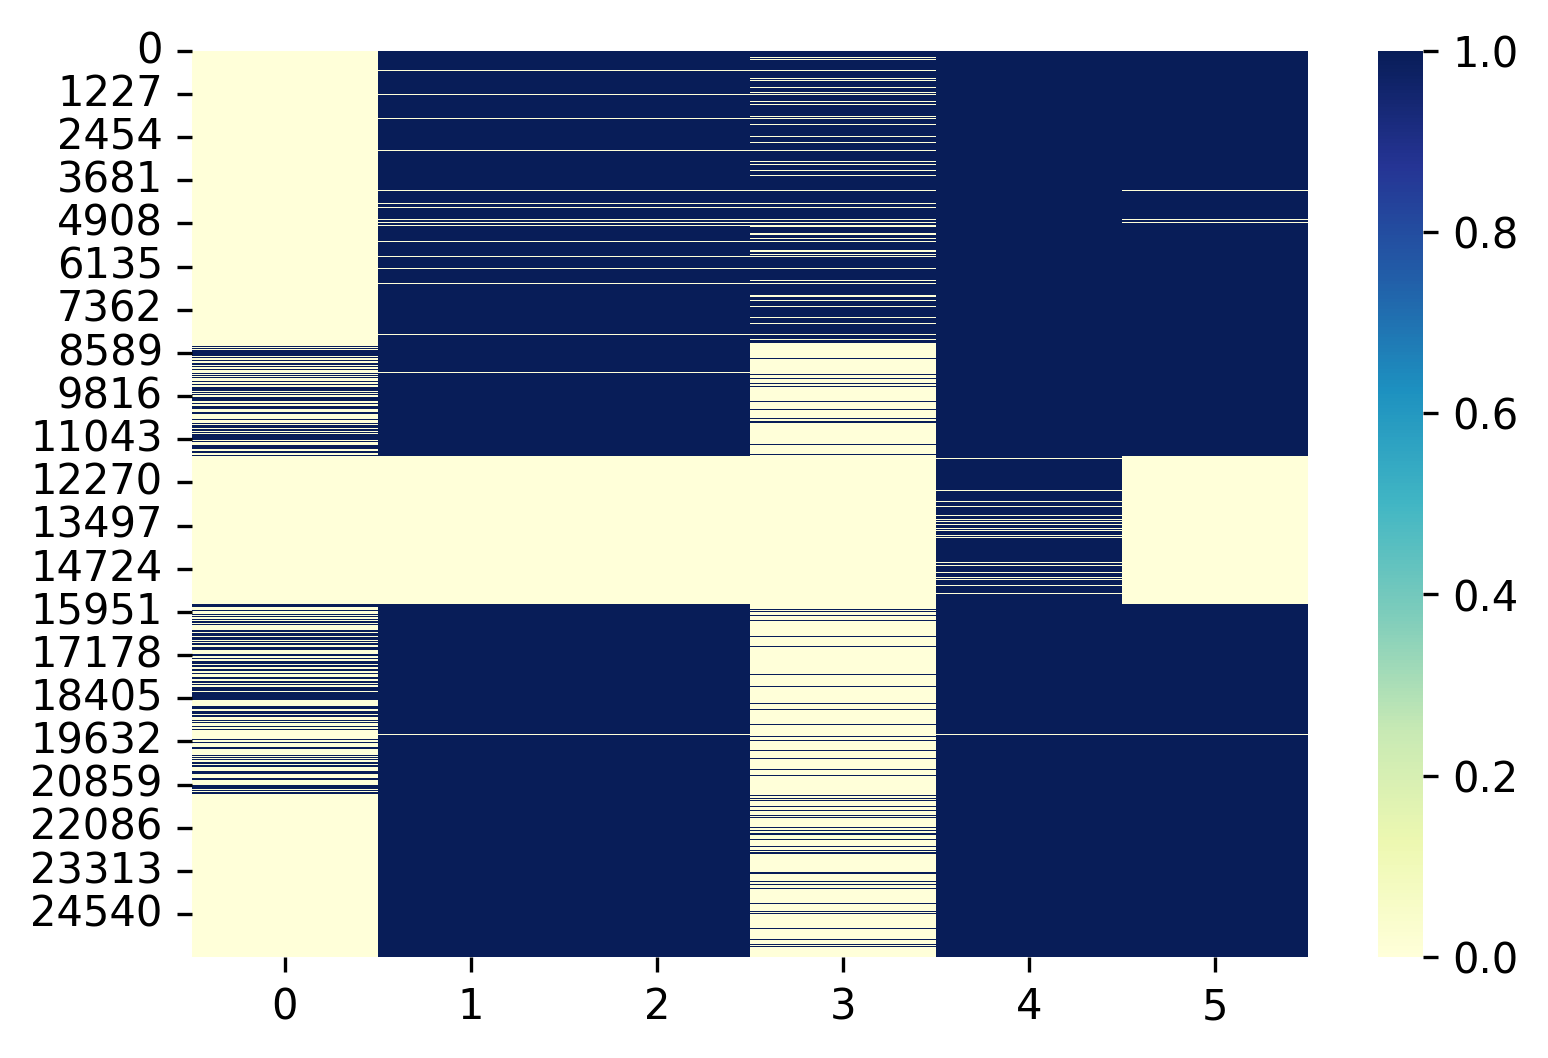

[[0 0 0 0 0 0]
 [0 0 0 0 1 0]
 [0 0 0 0 1 1]
 [0 1 1 0 1 1]
 [0 1 1 1 1 1]
 [1 1 1 0 1 1]]


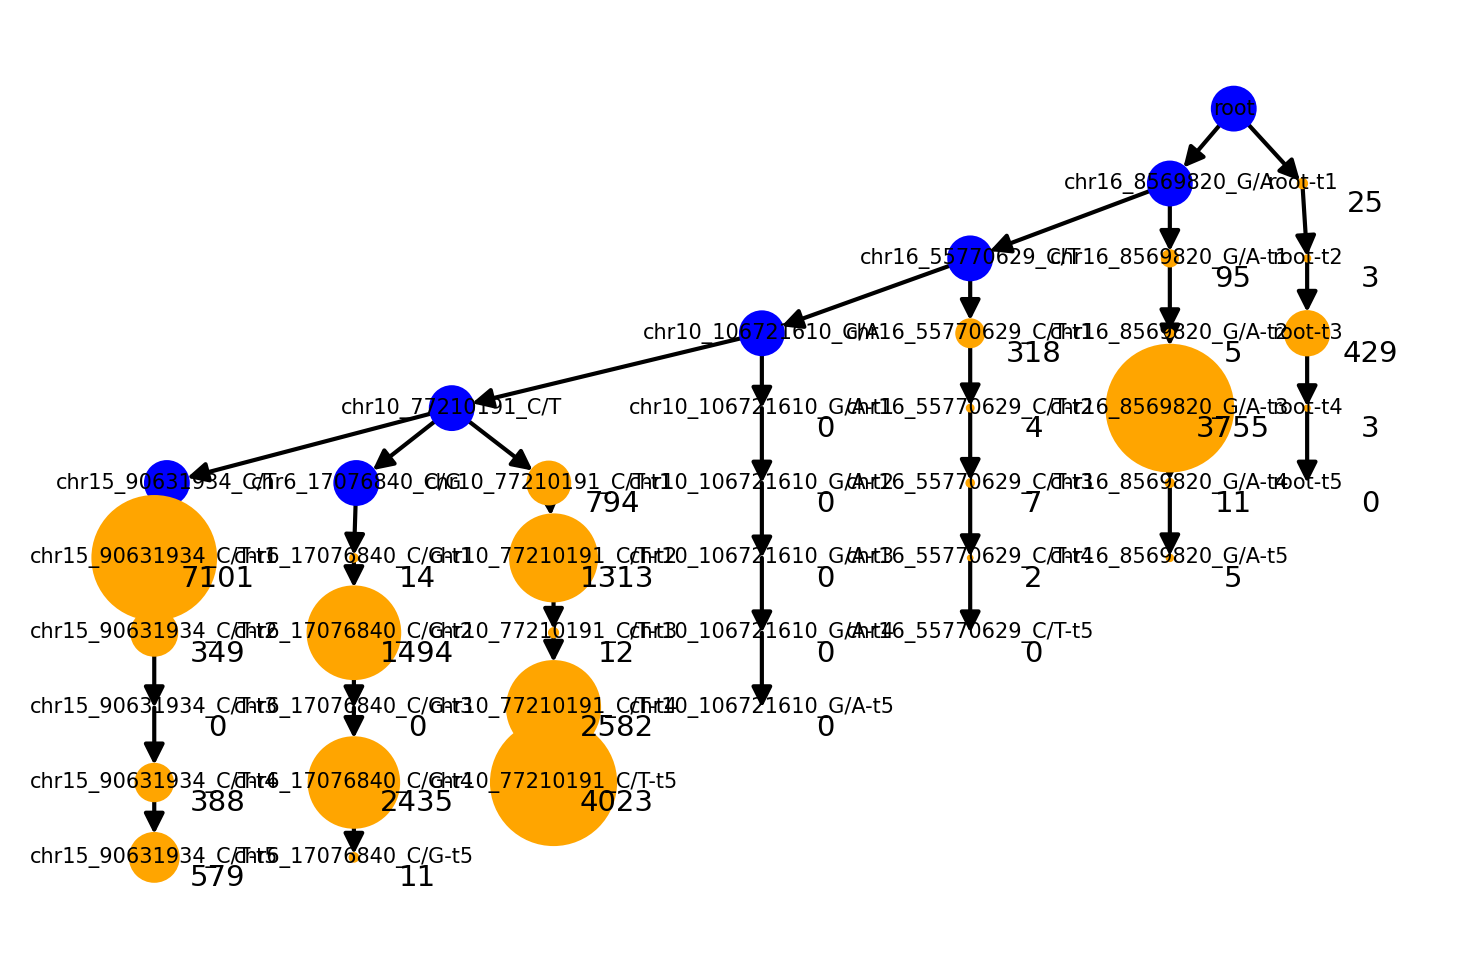

1021512.8727490642


In [219]:
sphyr_mat = analyze_SPhyR_results("AML-63", 5)

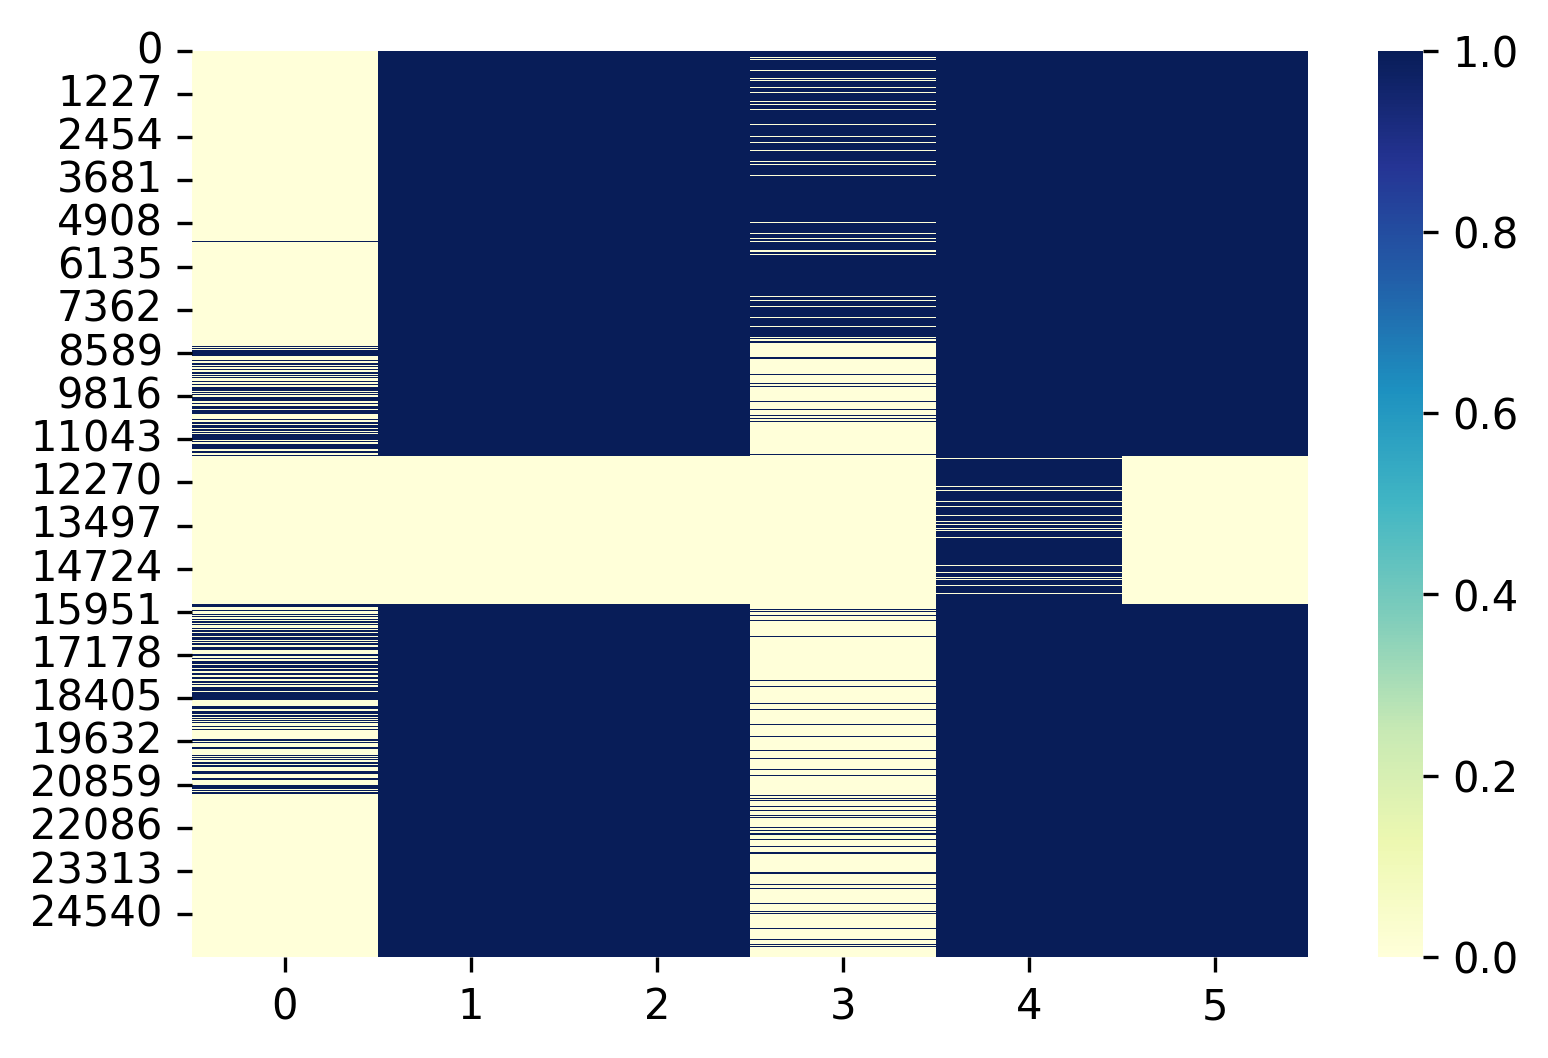

25757
[[0 0 0 0 0 0]
 [1 1 1 0 1 1]
 [0 1 1 0 1 1]
 [0 1 1 1 1 1]
 [0 0 0 0 1 0]]


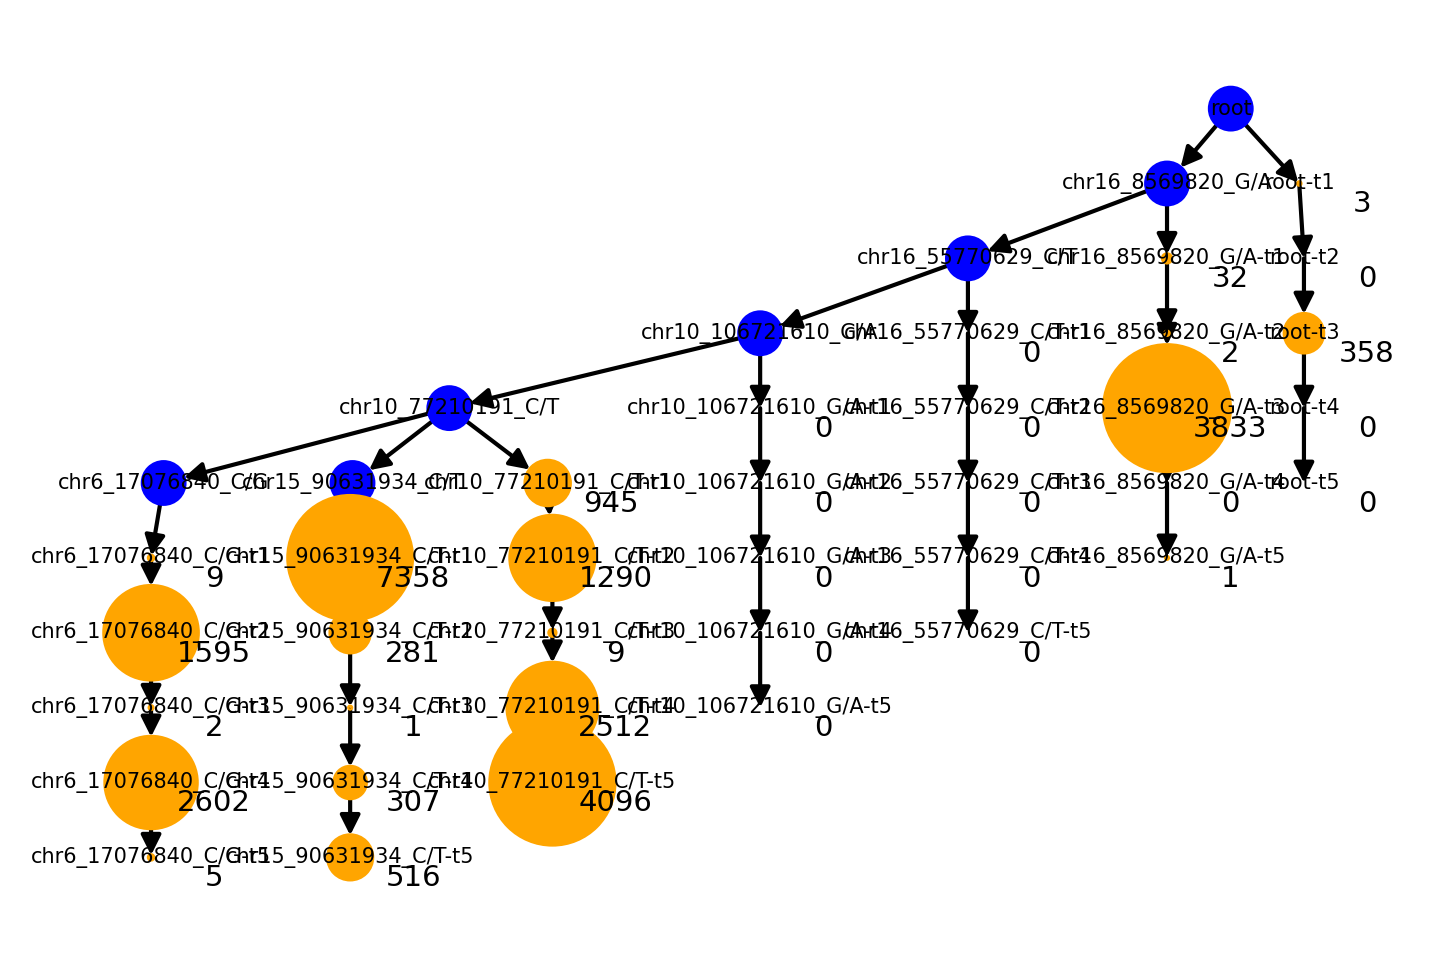

1041353.0126642344


In [220]:
compass_mat = analyze_COMPASS_results("AML-63", 5)

25757


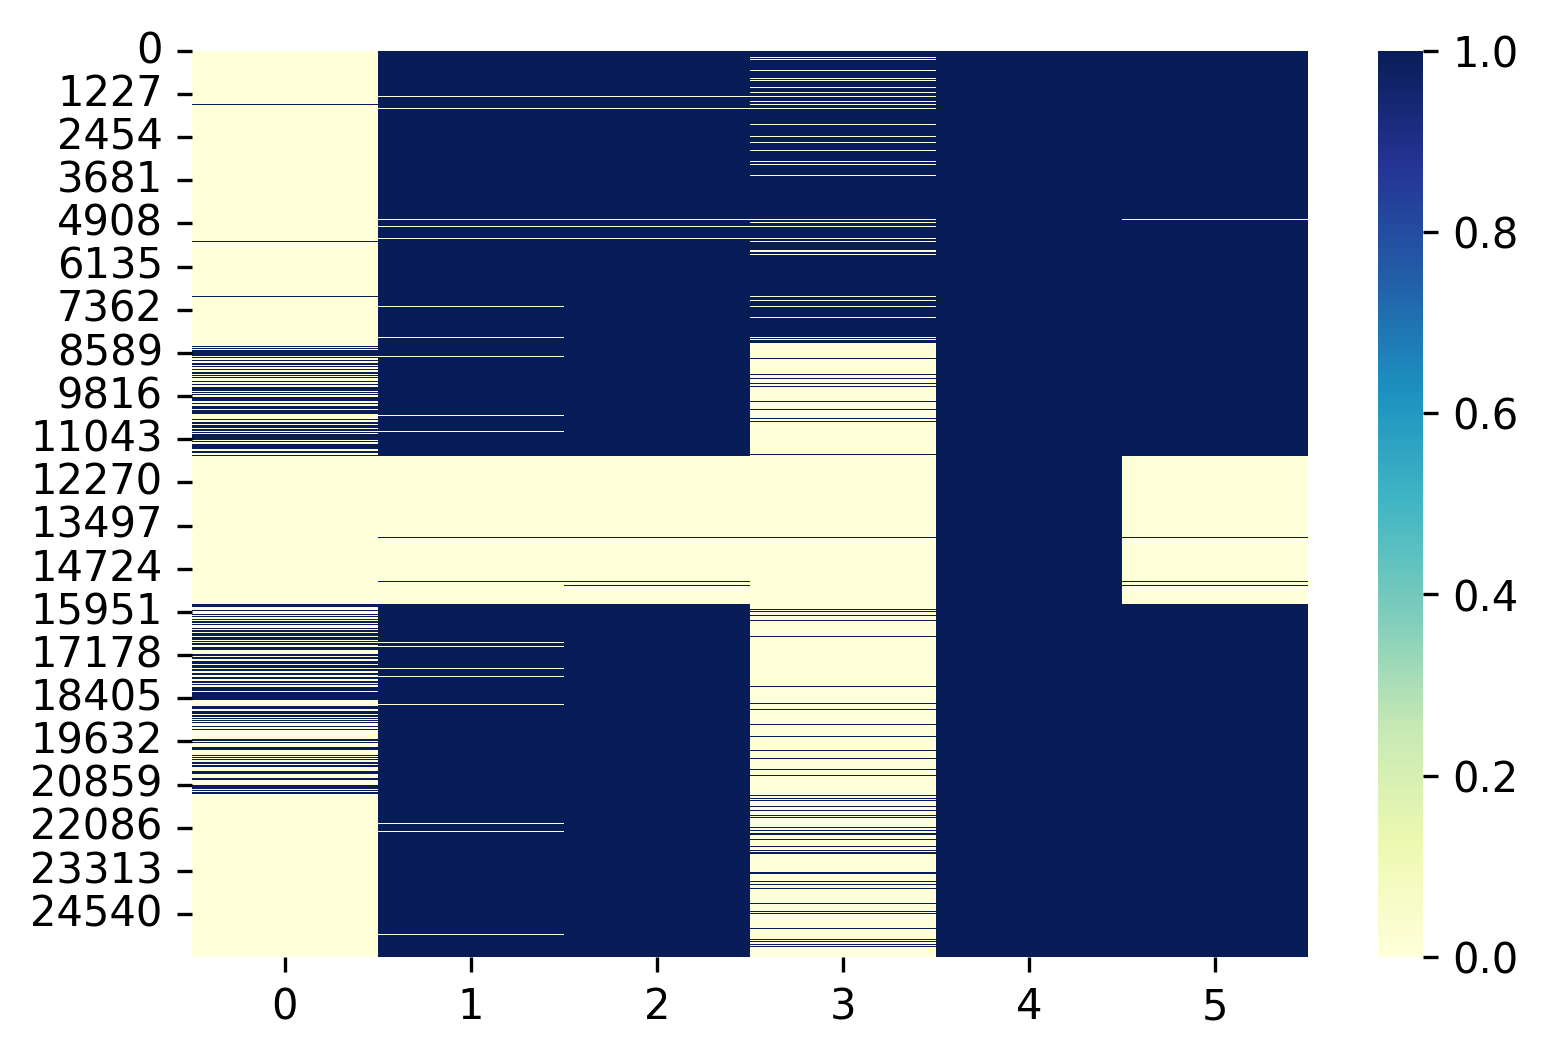

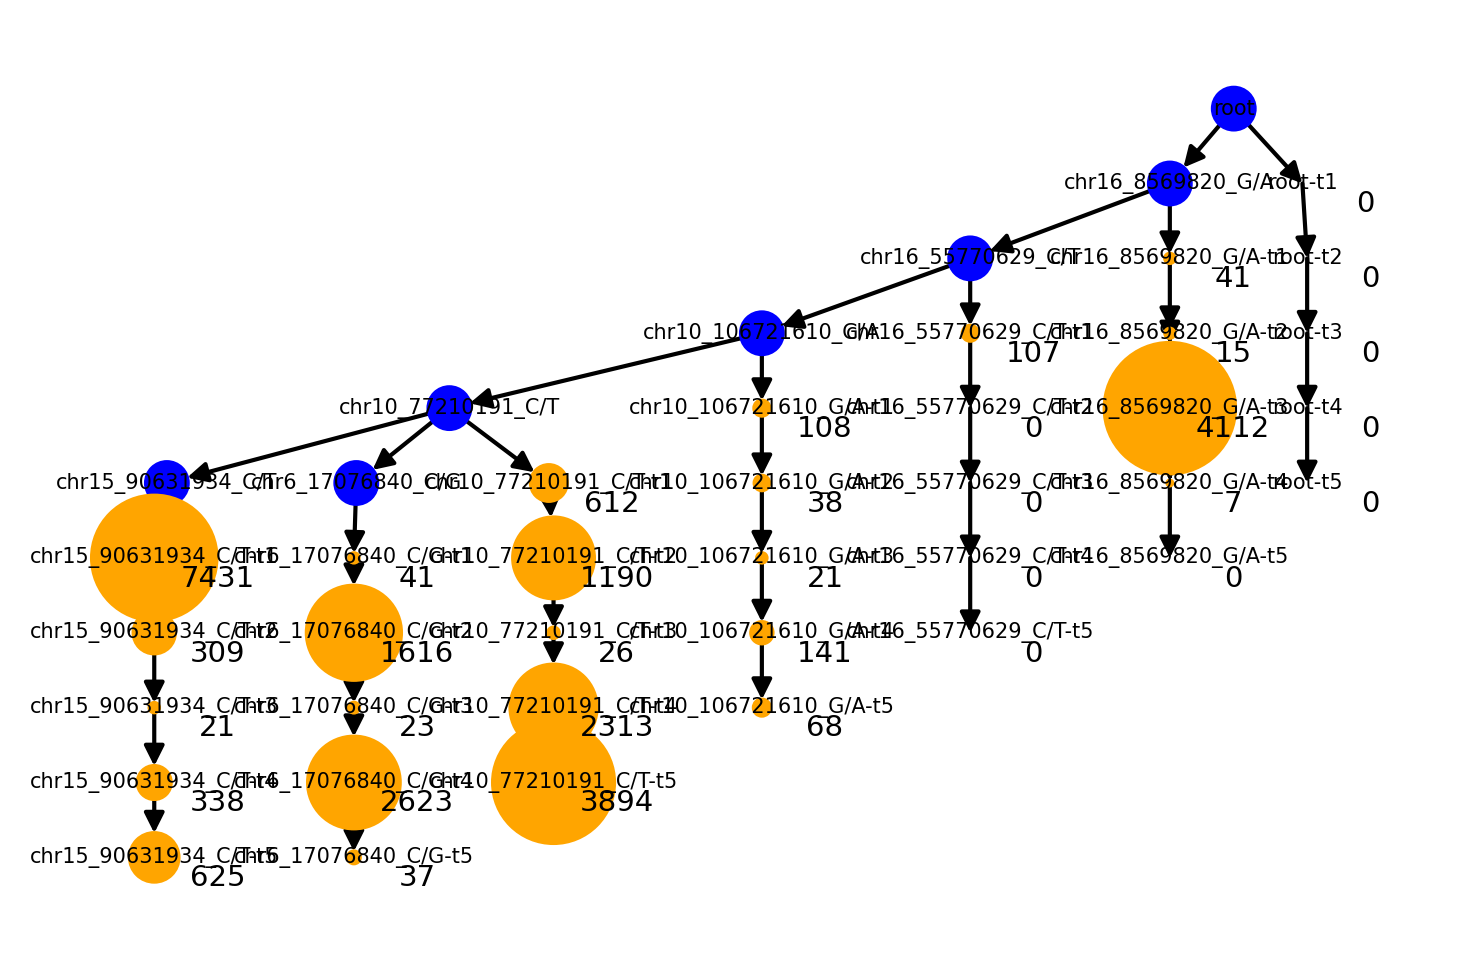

1063410.235564379


In [221]:
phyllochron_mat = analyze_Phyllochron_results("AML-63", 5)

In [349]:
RC_likelihood = analyze_RC_likelihood('AML-63', 5, phyllochron_mat, compass_mat, sphyr_mat, prop=0.01)

In [350]:
COMPASS_likelihood = analyze_COMPASS_likelihood('AML-63', 5, phyllochron_mat, compass_mat, sphyr_mat, prop=0.047)

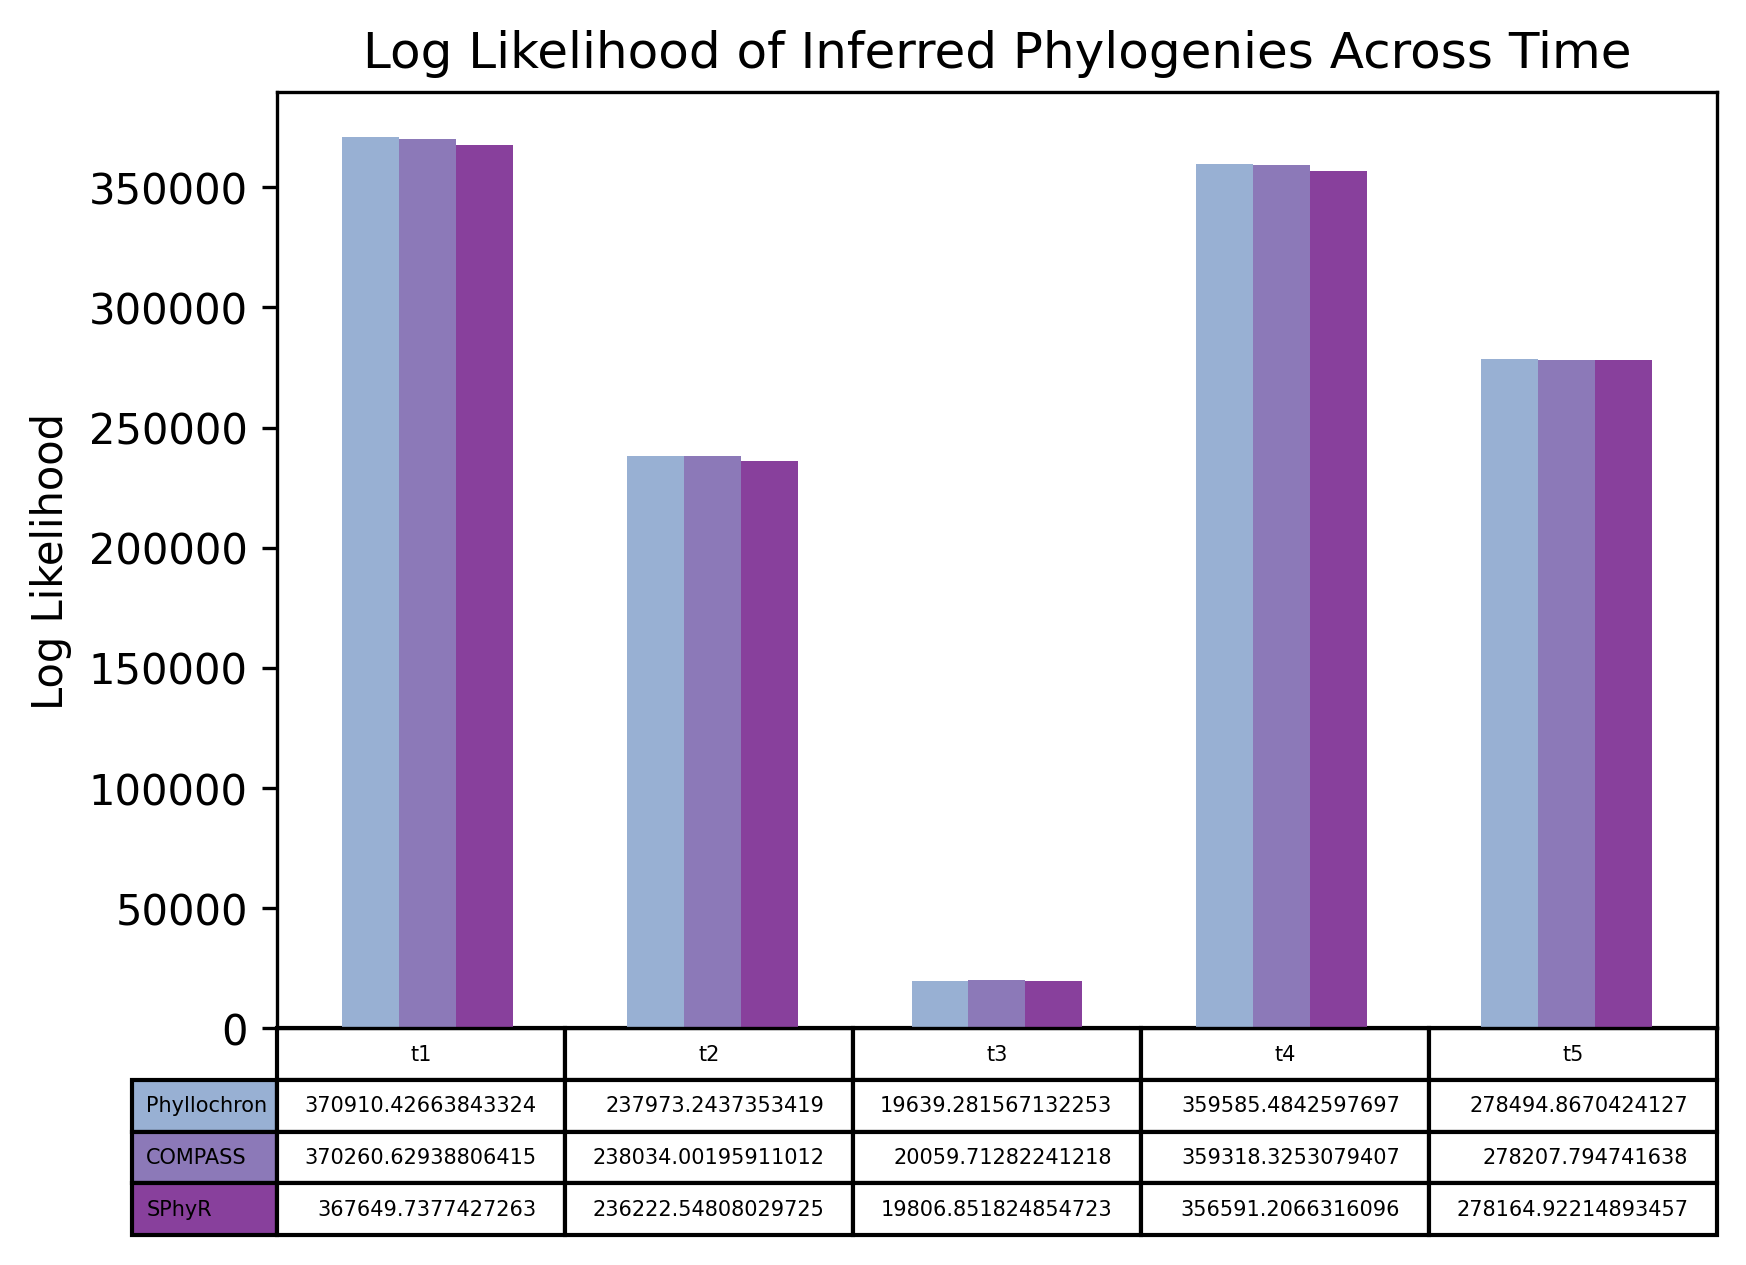

In [384]:
visualize_likelihood('AML-63', 5, RC_likelihood)

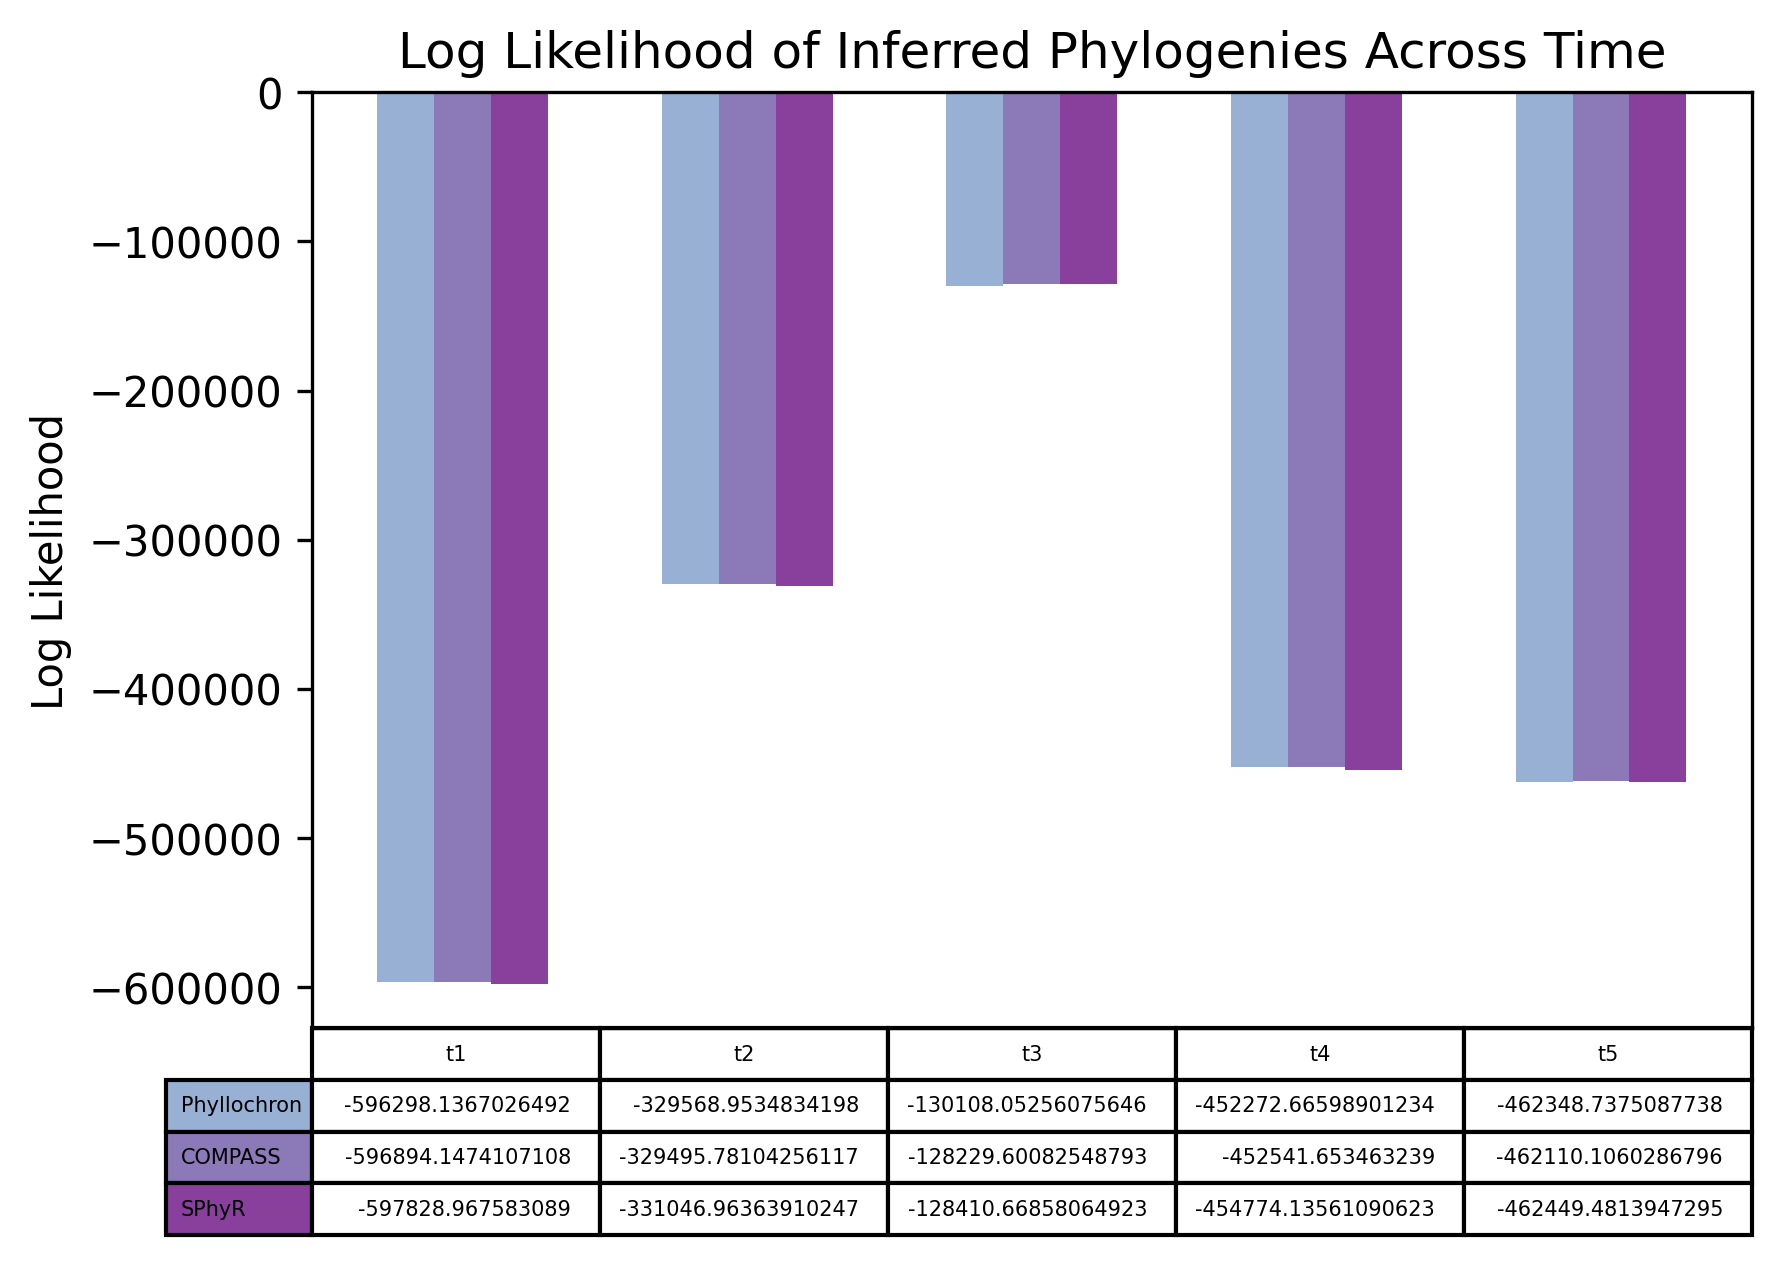

In [391]:
visualize_likelihood('AML-63', 5, COMPASS_likelihood)

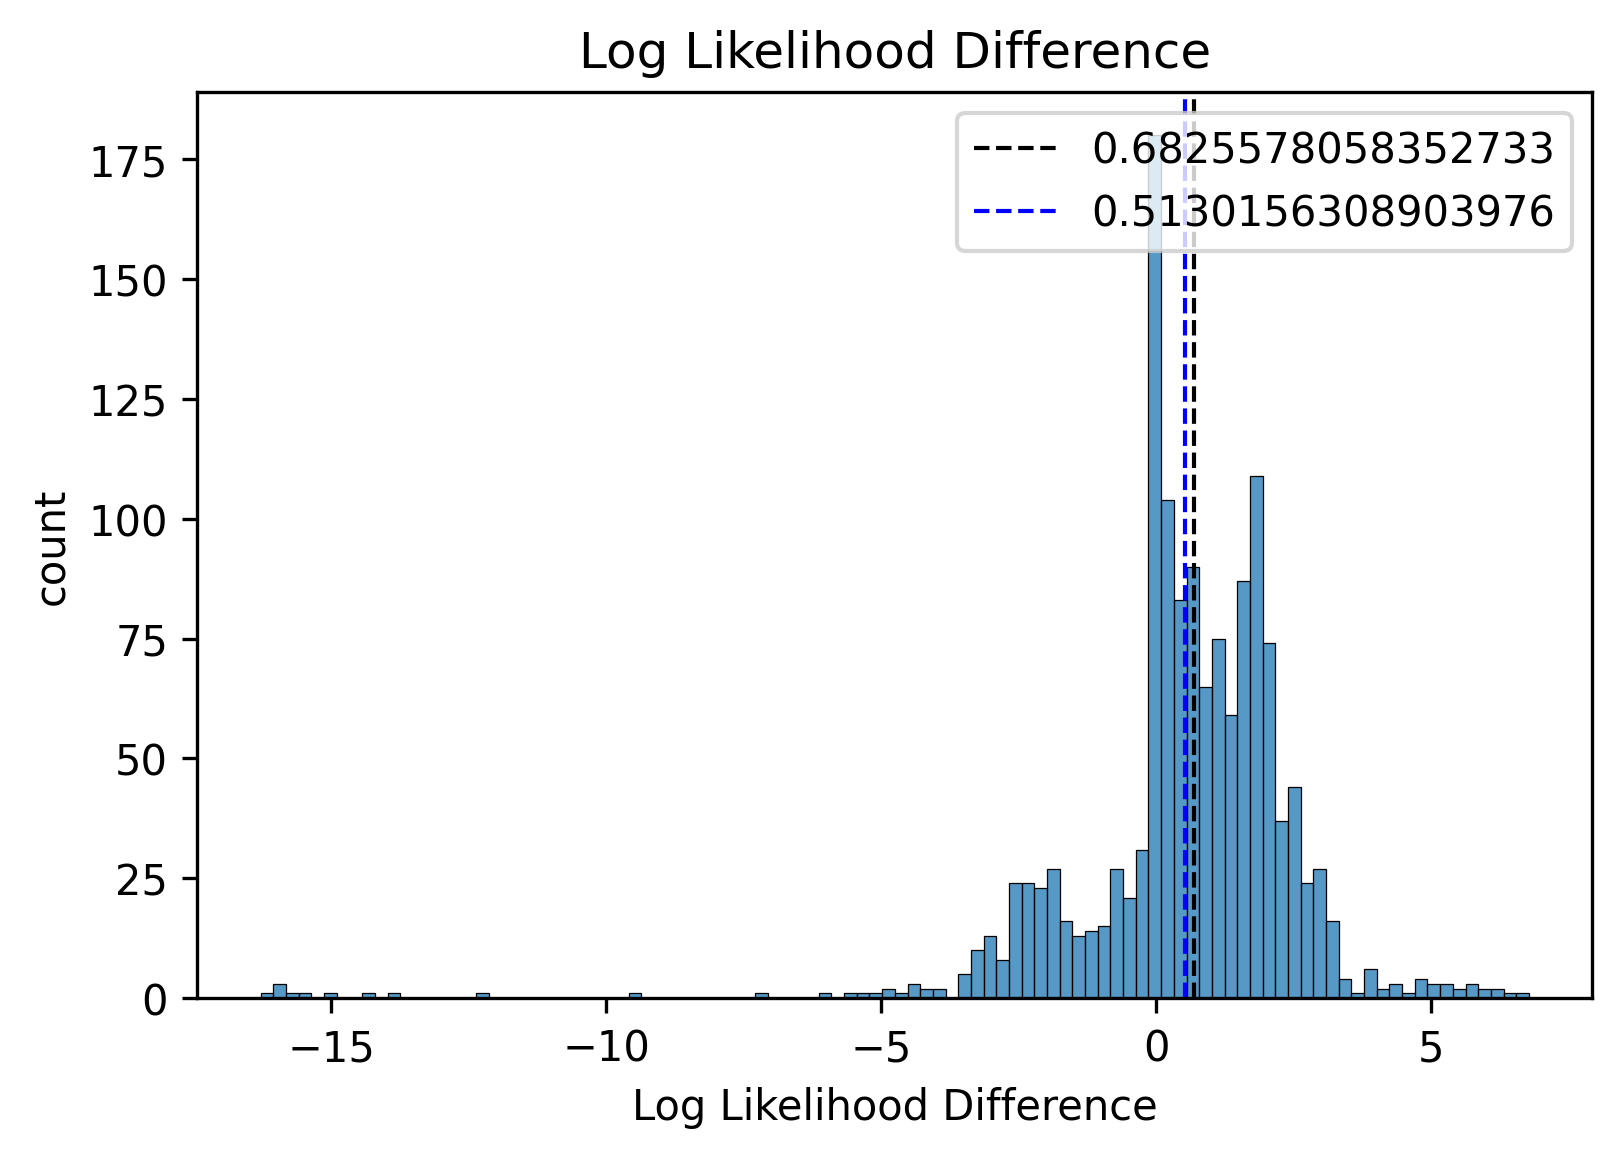

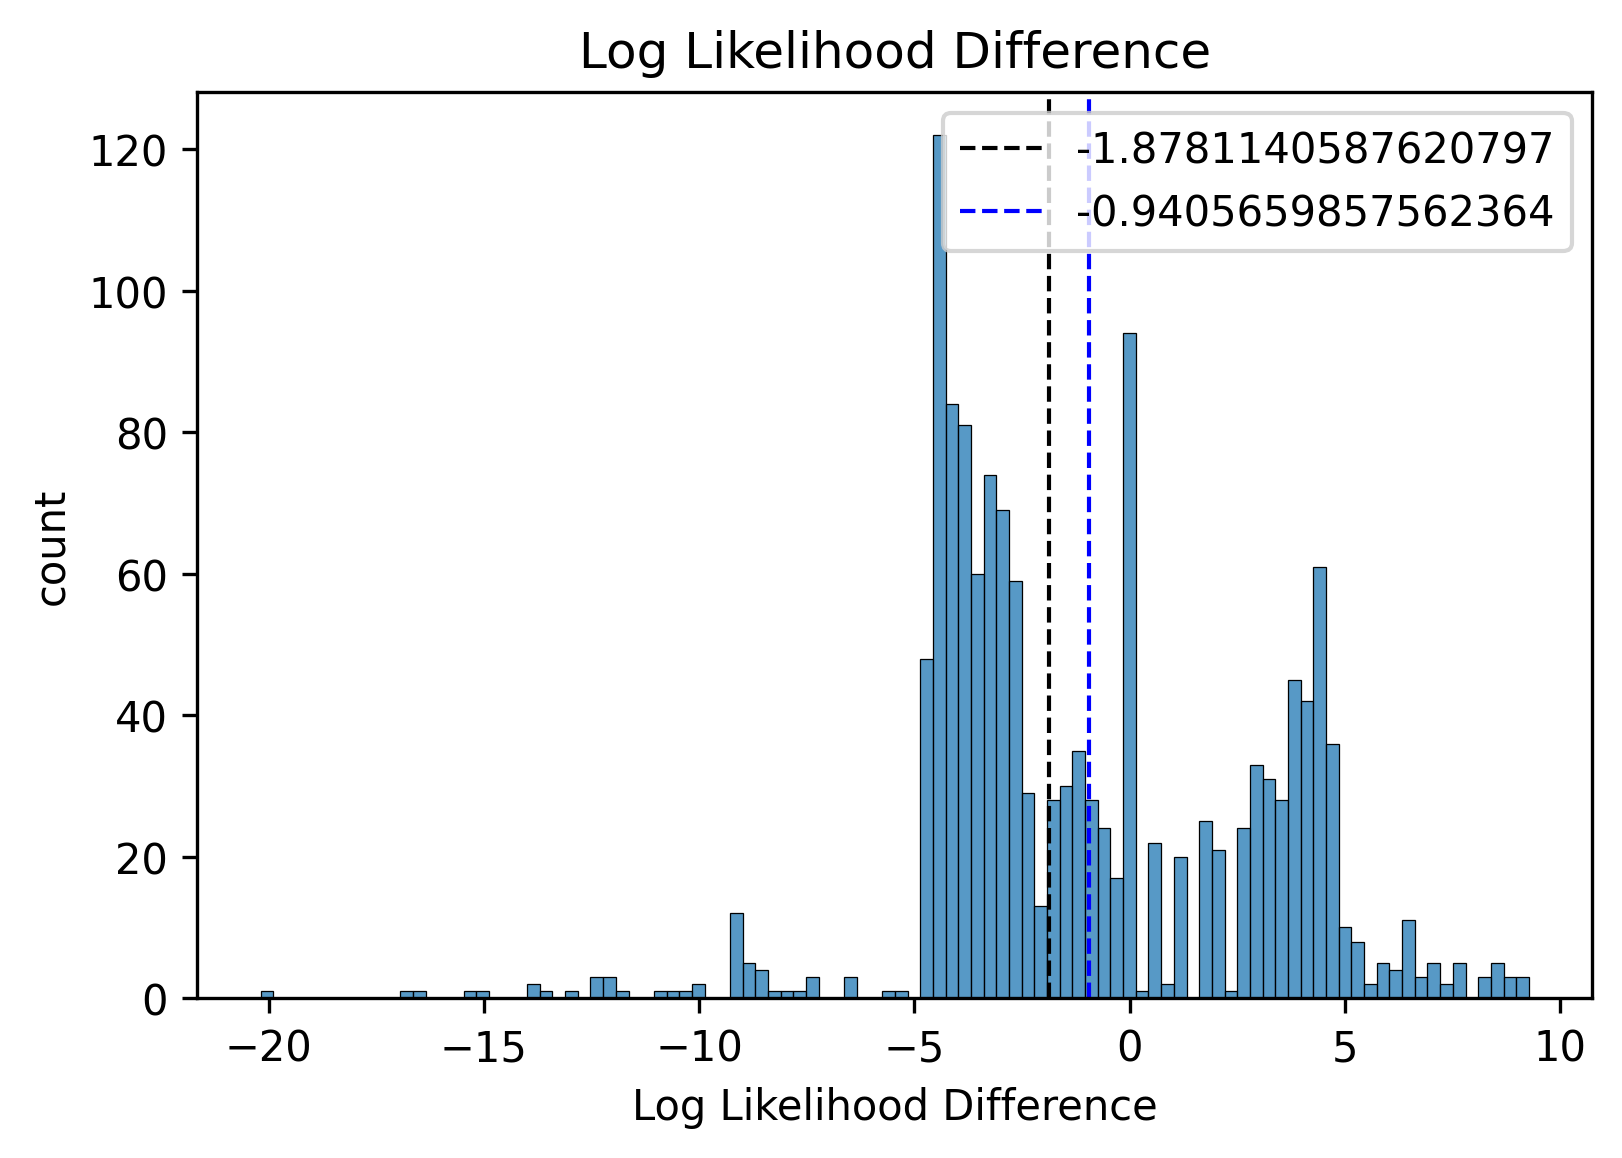

In [392]:
compare_RC_likelihood('AML-63', 5, phyllochron_mat, compass_mat, prop=0.01)
compare_COMPASS_likelihood('AML-63', 5, phyllochron_mat, compass_mat, prop=0.047)

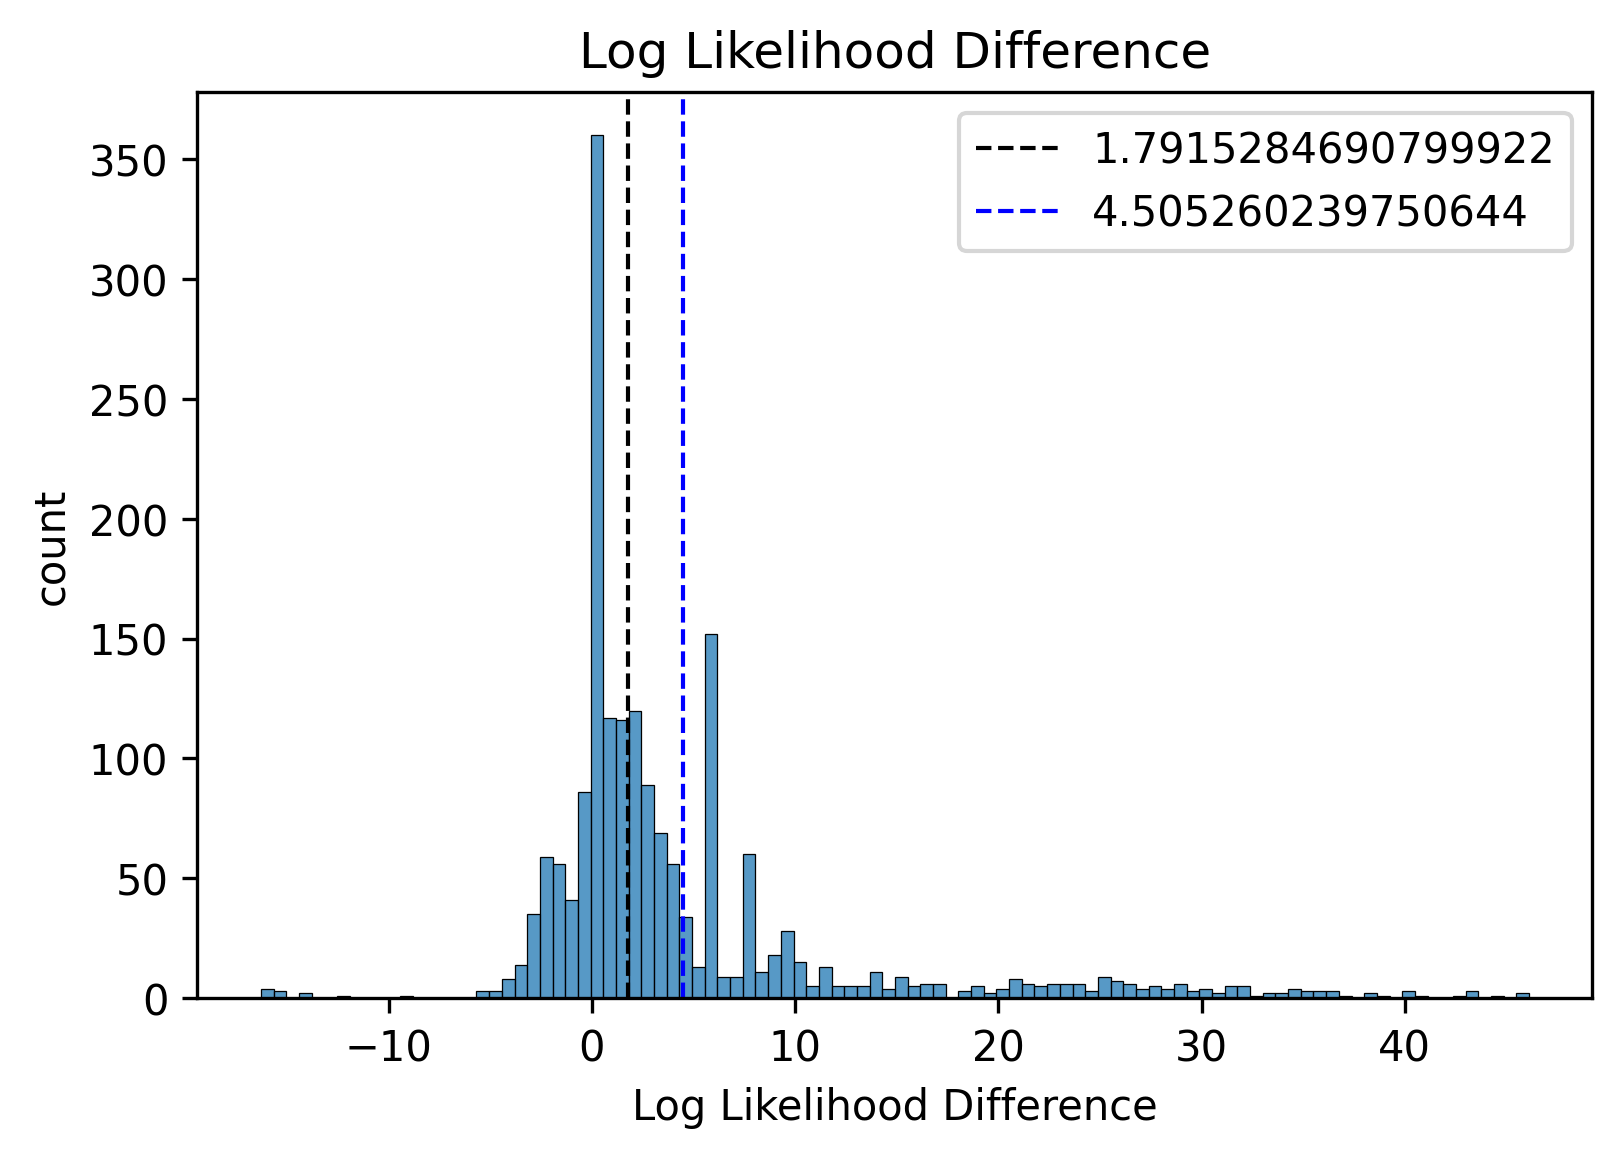

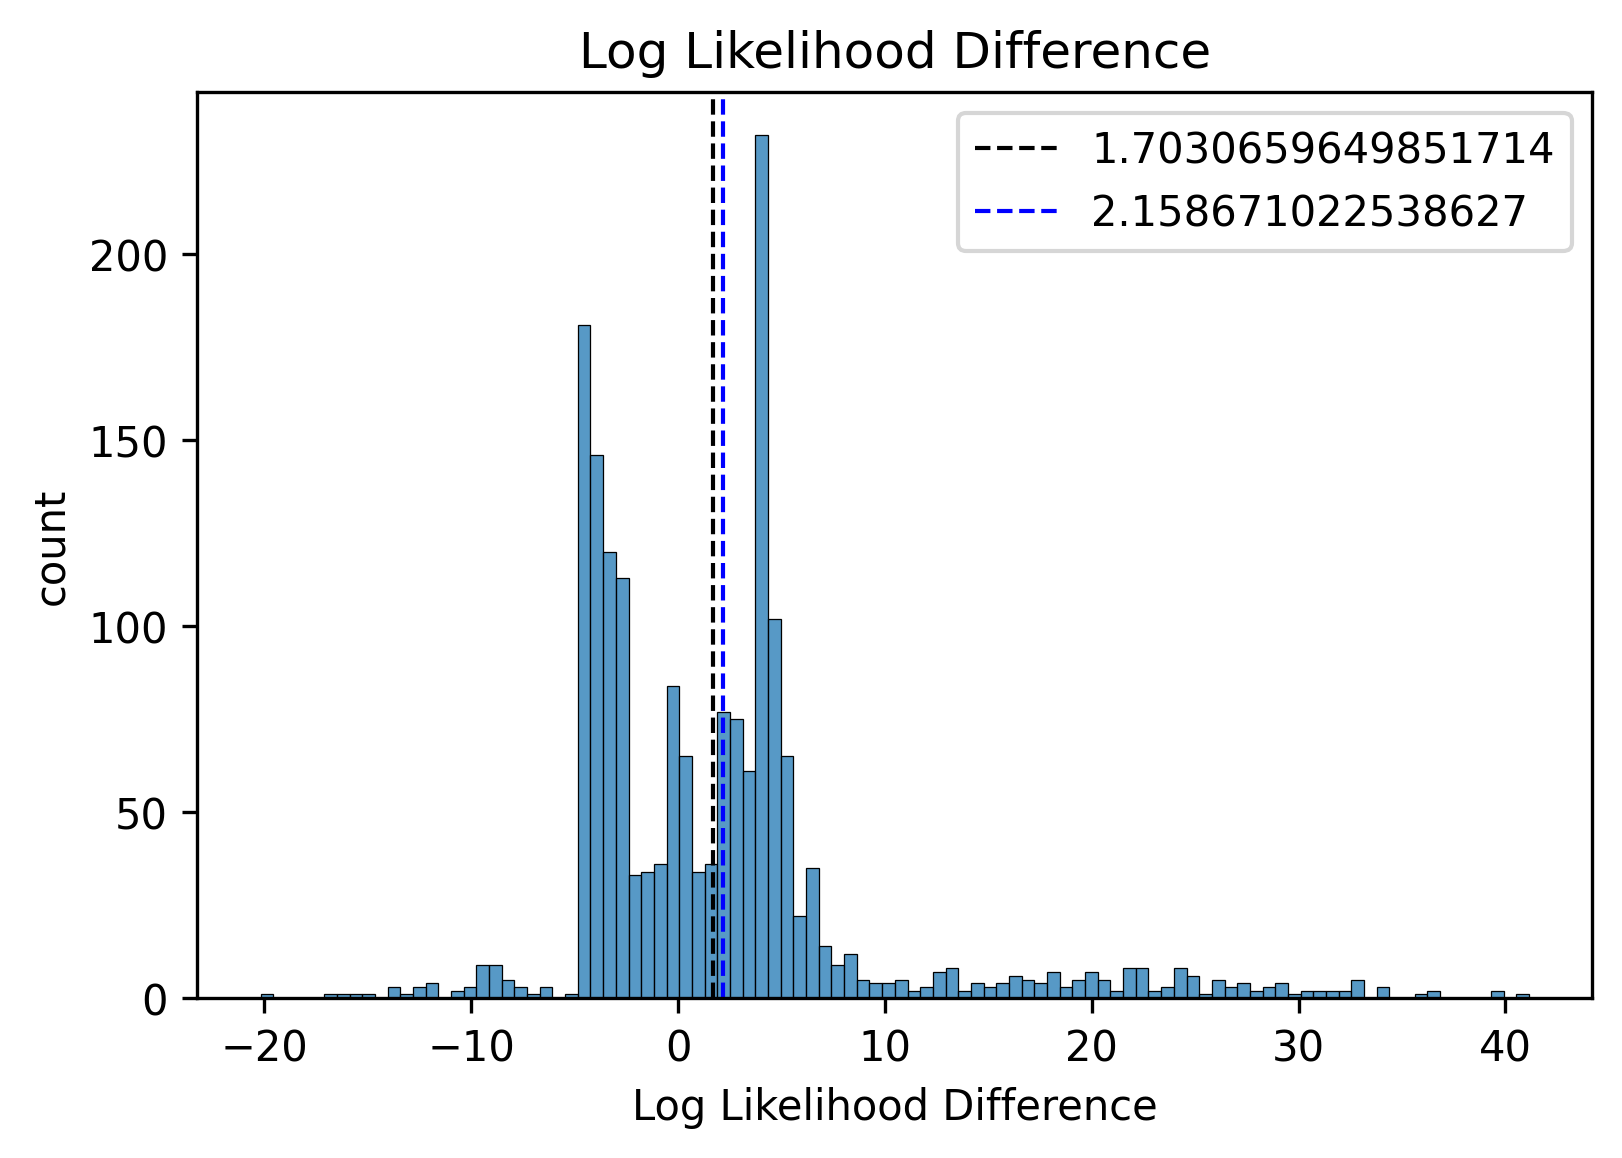

In [393]:
compare_RC_likelihood('AML-63', 5, phyllochron_mat, sphyr_mat, prop=0.01)
compare_COMPASS_likelihood('AML-63', 5, phyllochron_mat, sphyr_mat, prop=0.047)

[[ 15.  10.  36.  45.  34.  16.]
 [121.  14.  49.  45.  32.  26.]
 [ 12.   9.  25.  25.  60.  12.]
 ...
 [ 90.  32. 111. 128.  21.  84.]
 [115.  33. 144. 180.  37. 136.]
 [ 25. 112.  30.  54.   8.  16.]]


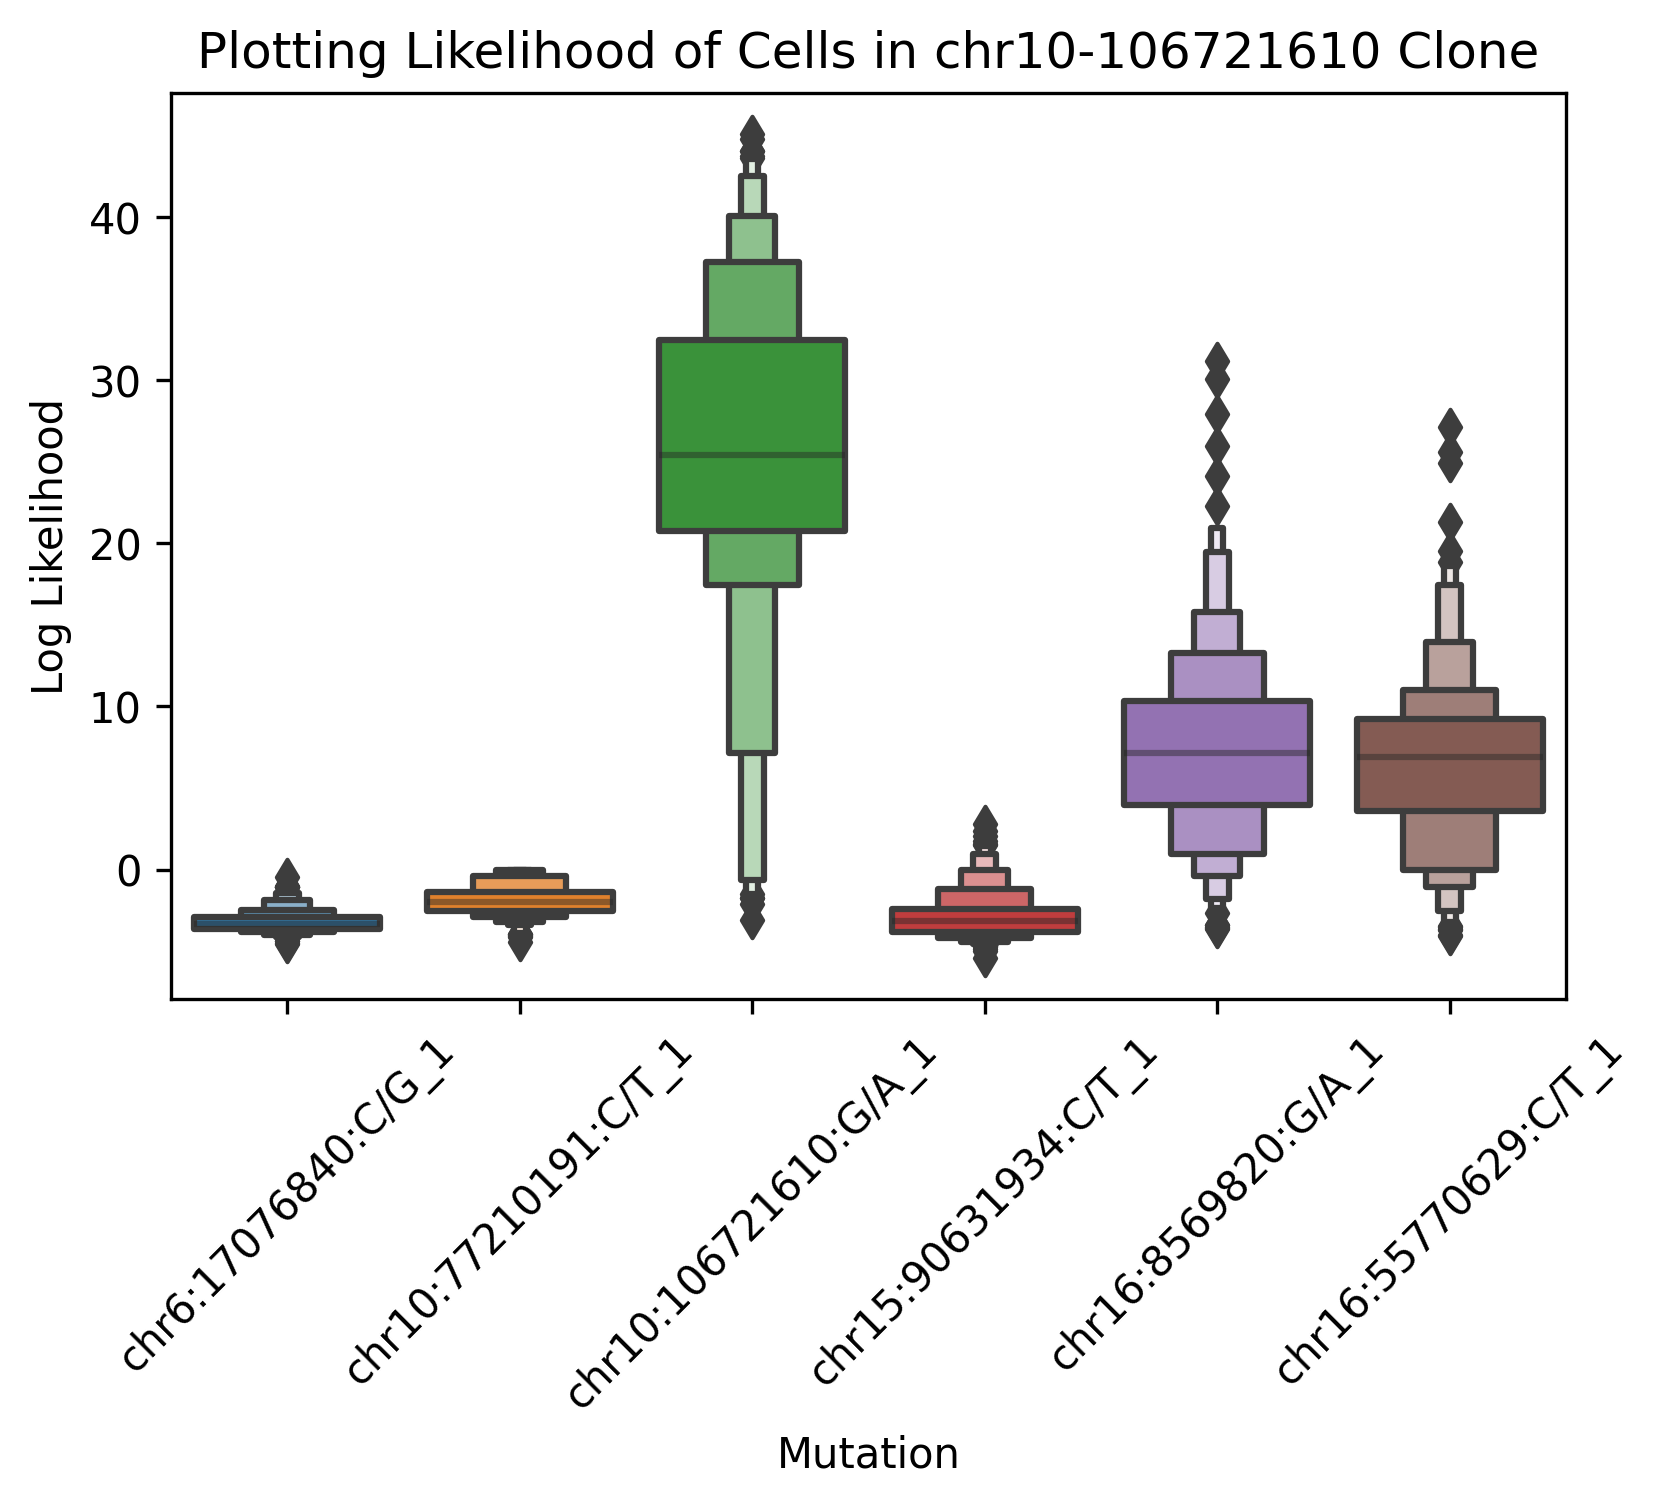

In [366]:
compute_Phyllochron_rc_likelihood('AML-63', np.array([0,0,1,0,1,1]), prop=0.01)

[[ 15.  10.  36.  45.  34.  16.]
 [121.  14.  49.  45.  32.  26.]
 [ 12.   9.  25.  25.  60.  12.]
 ...
 [ 90.  32. 111. 128.  21.  84.]
 [115.  33. 144. 180.  37. 136.]
 [ 25. 112.  30.  54.   8.  16.]]


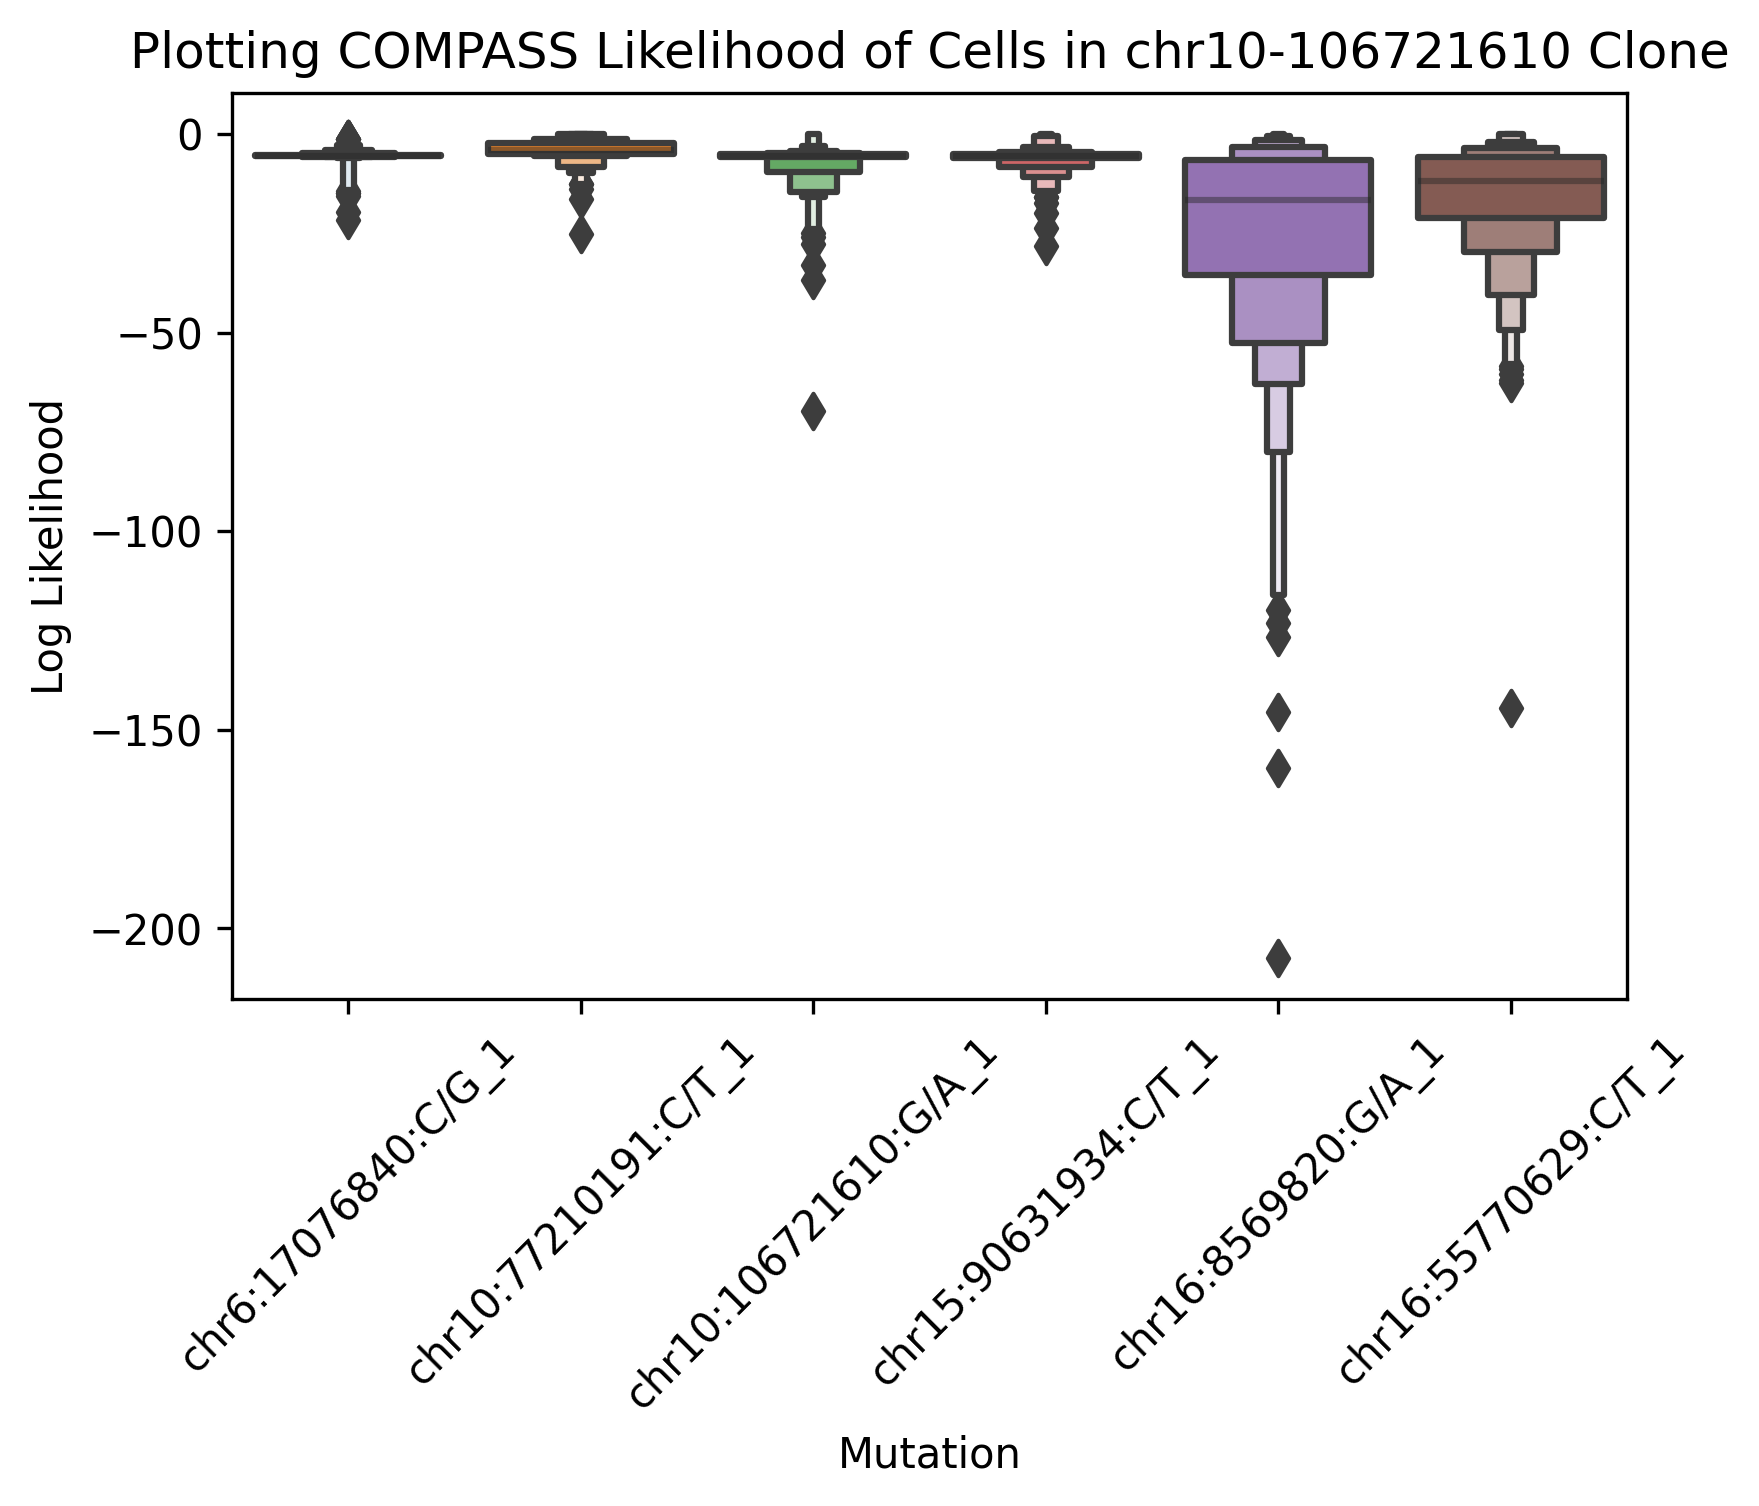

In [395]:
compute_Phyllochron_COMPASS_likelihood('AML-63', np.array([0,0,1,0,1,1]), prop=0.047)

# AML-97 Analysis

19332


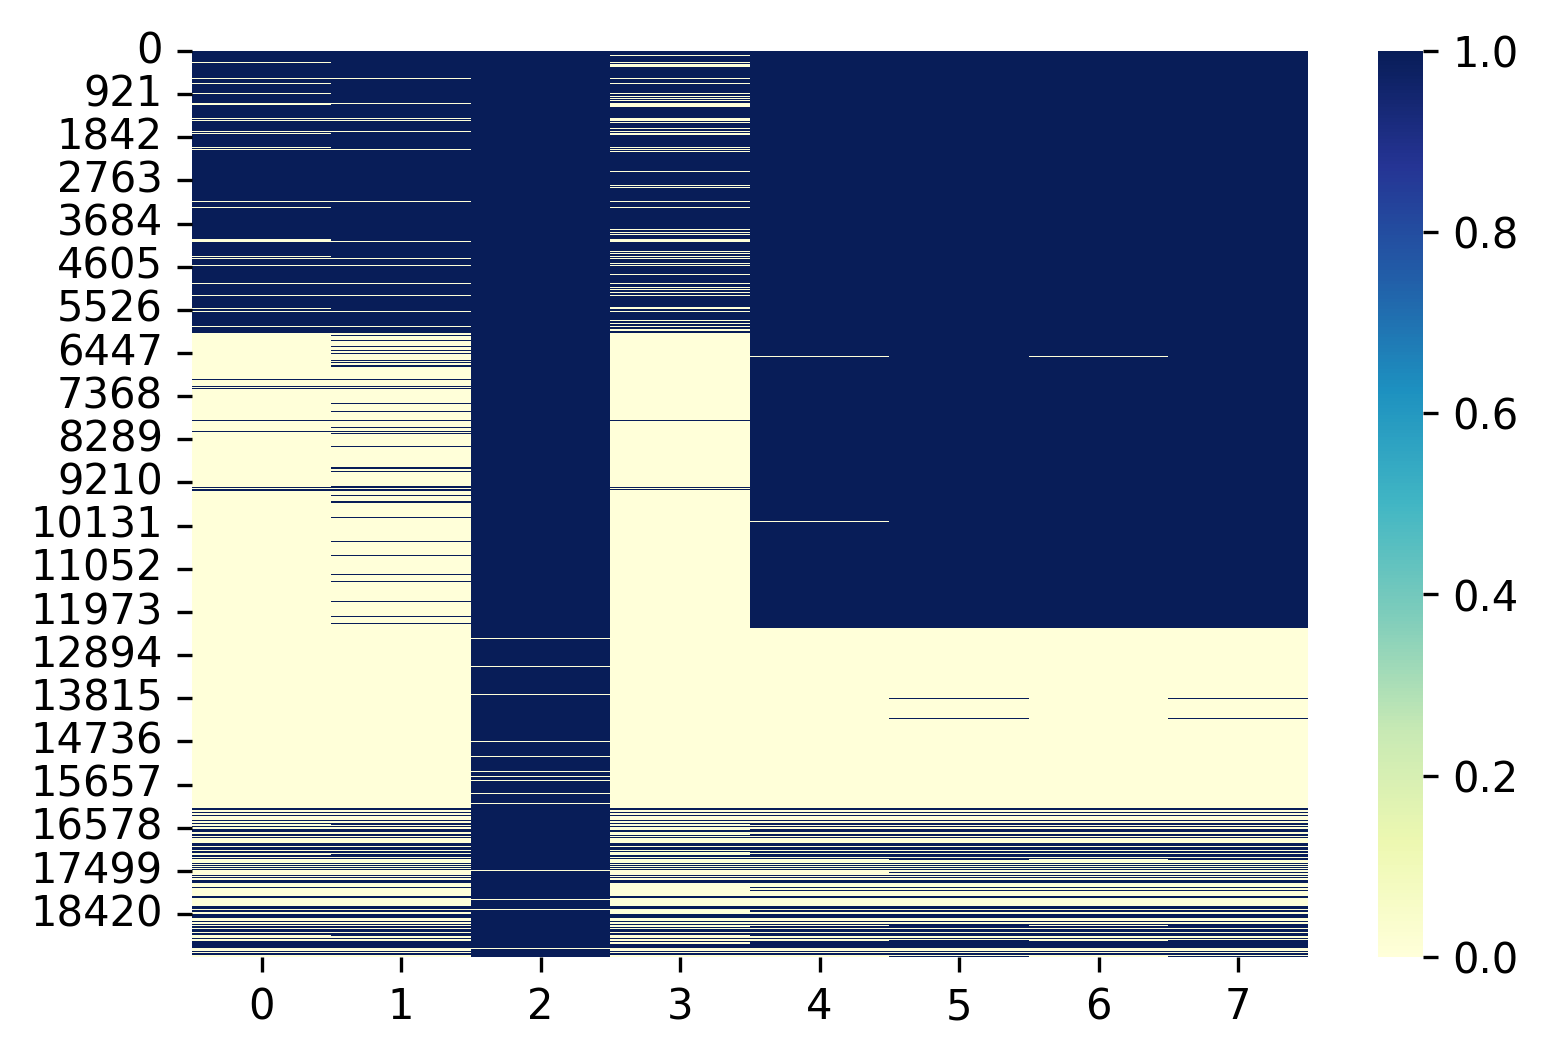

[[0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0]
 [0 0 1 0 0 1 0 1]
 [0 0 1 0 0 1 1 1]
 [0 0 1 0 1 1 1 1]
 [0 1 1 0 1 1 1 1]
 [1 1 1 0 1 1 1 1]
 [1 1 1 1 1 1 1 1]]
[[0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0]
 [0 0 1 0 0 1 0 1]
 [0 0 1 0 0 1 1 1]
 [0 0 1 0 1 1 1 1]
 [0 1 1 0 1 1 1 1]
 [1 1 1 0 1 1 1 1]
 [1 1 1 1 1 1 1 1]
 [0 0 1 0 0 1 0 0]]


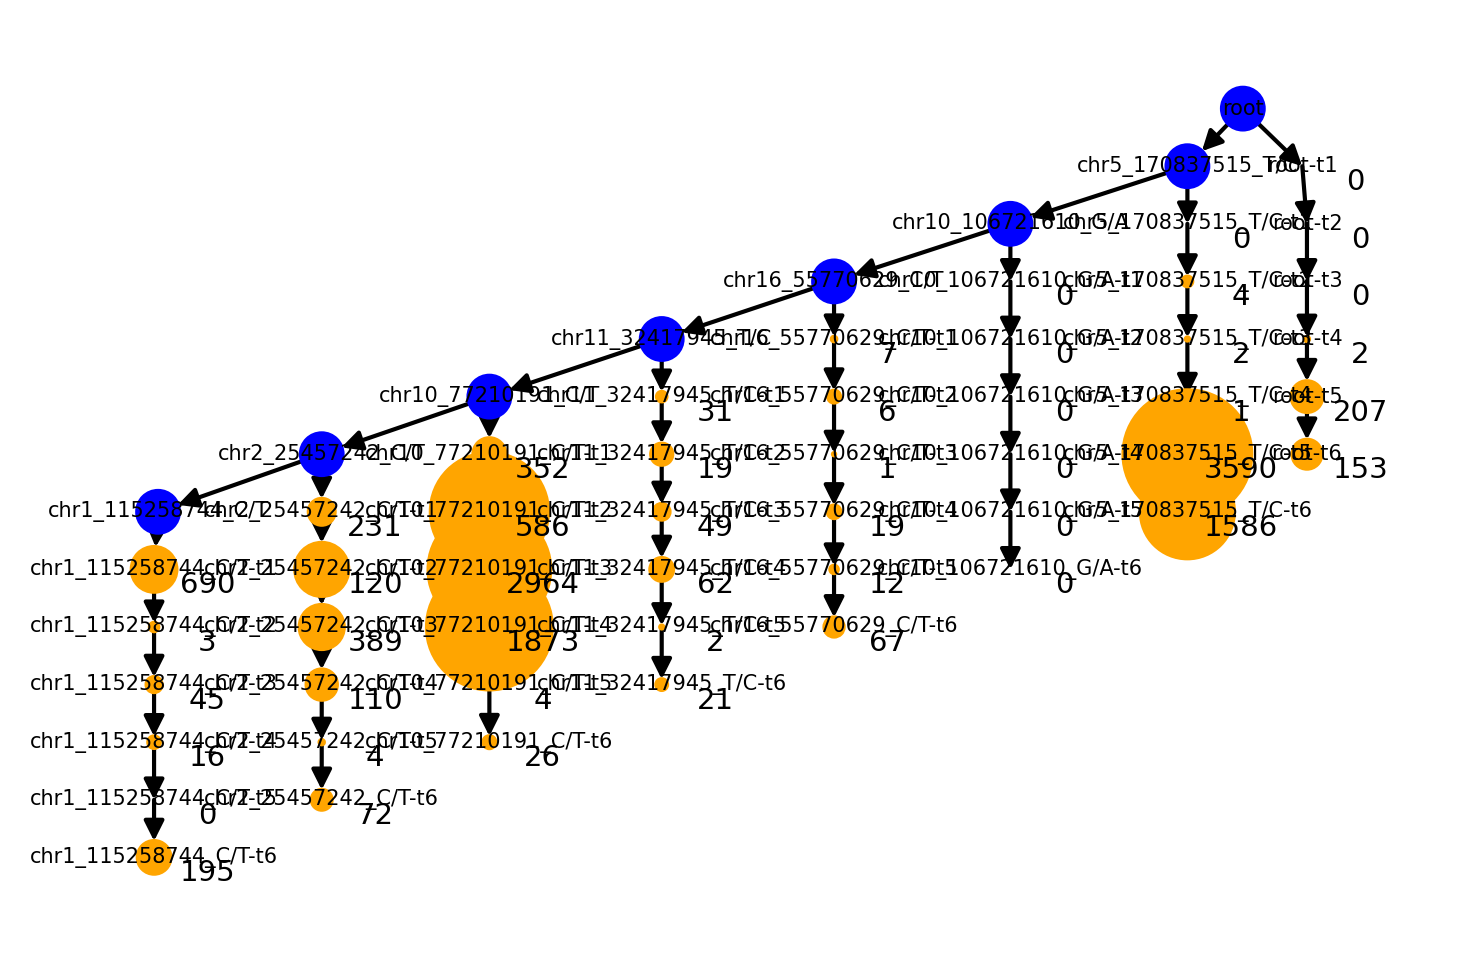

1157936.4094692946


array([[1, 1, 1, ..., 1, 1, 1],
       [0, 0, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [0, 0, 1, ..., 0, 0, 0]])

In [401]:
analyze_SPhyR_results("AML-97", 6)

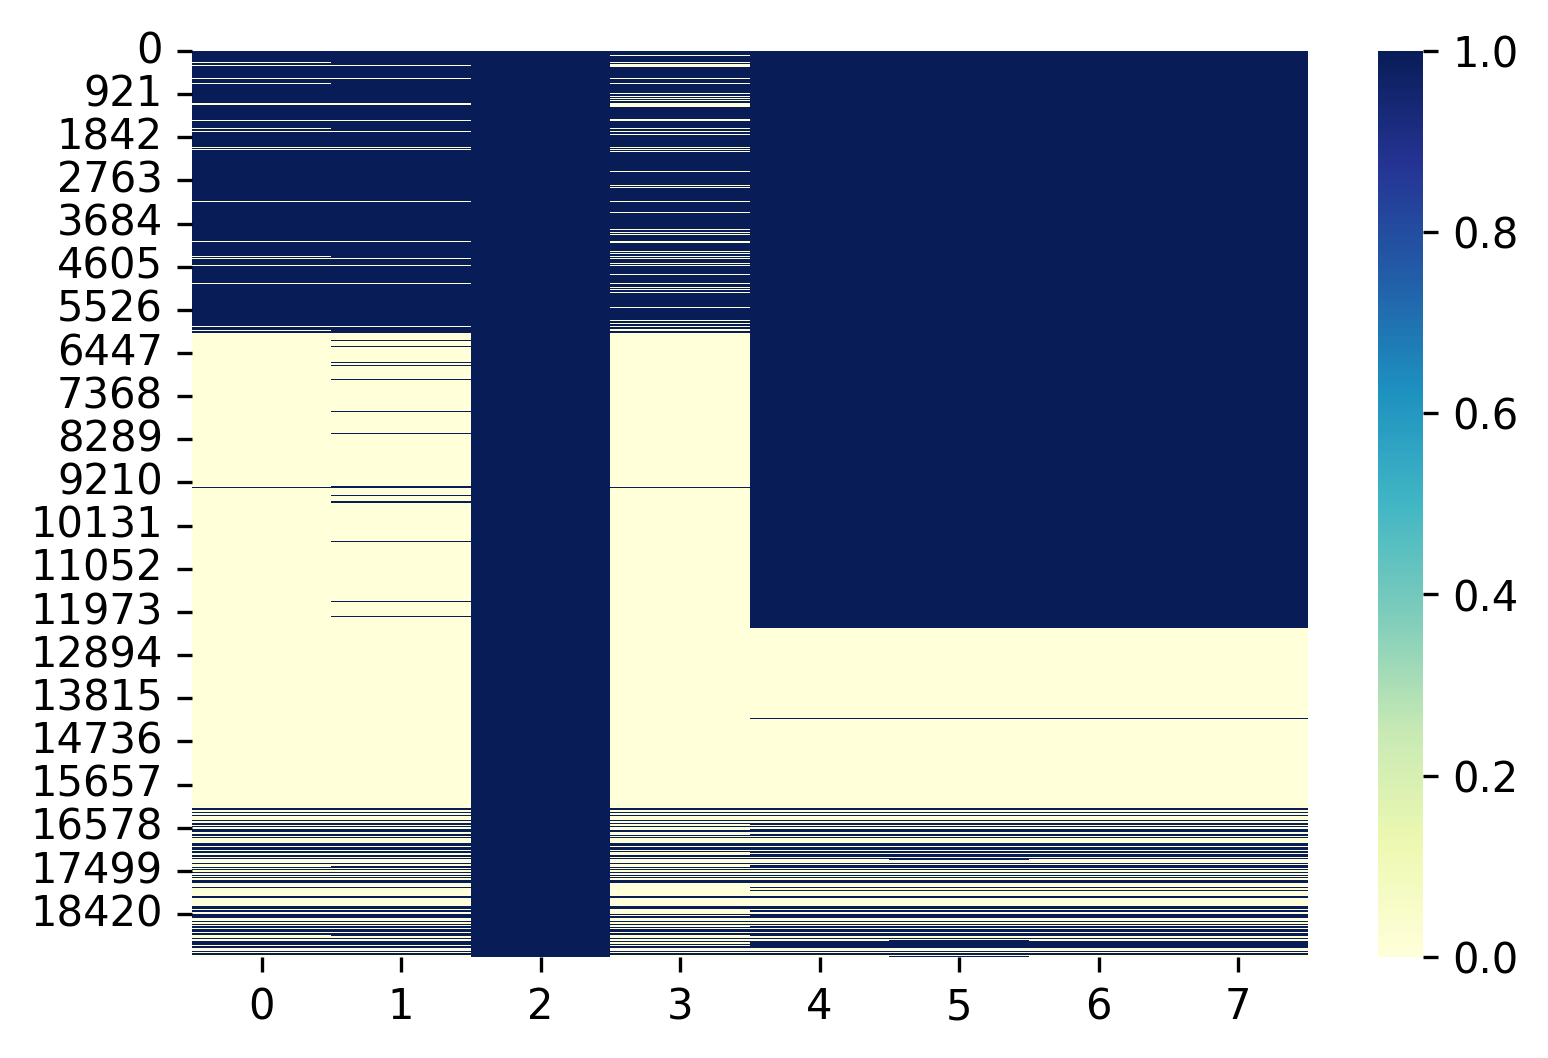

19332
[[0 0 1 0 0 0 0 0]
 [0 1 1 0 1 1 1 1]
 [0 0 1 0 1 1 1 1]
 [1 1 1 0 1 1 1 1]
 [0 0 1 0 0 1 0 0]
 [1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0]
 [0 0 1 0 0 1 0 1]
 [0 0 1 0 0 1 1 1]]


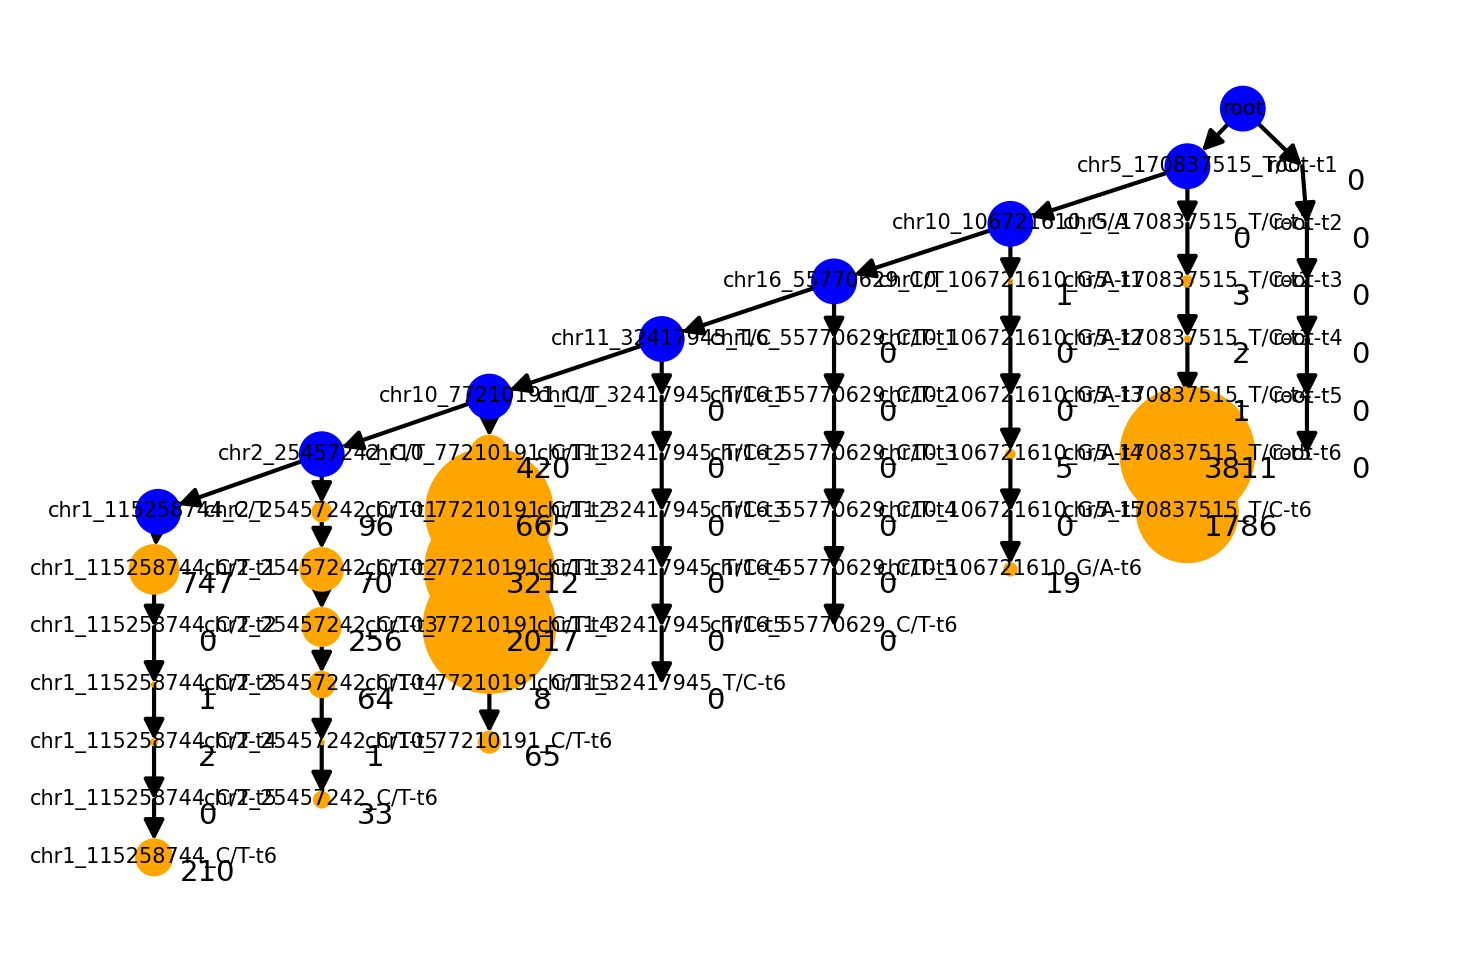

1158704.2182006617


array([[1., 1., 1., ..., 1., 1., 1.],
       [0., 0., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [0., 0., 1., ..., 0., 0., 0.]])

In [402]:
analyze_COMPASS_results("AML-97", 6)

[0 1]
19332


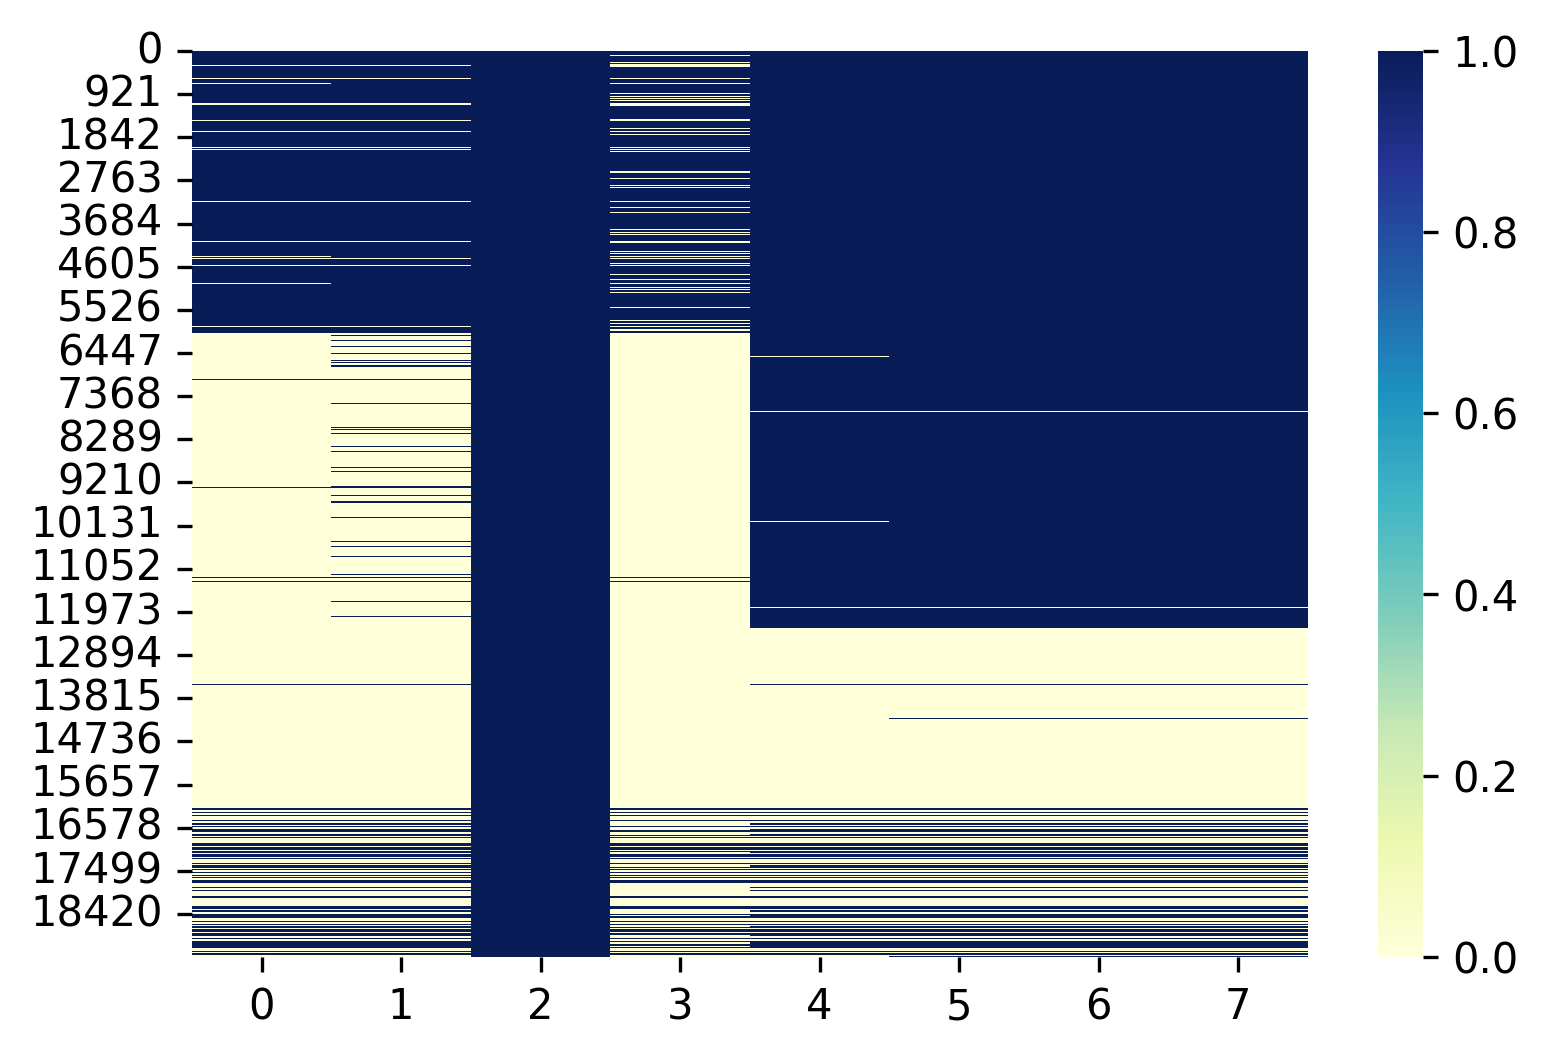

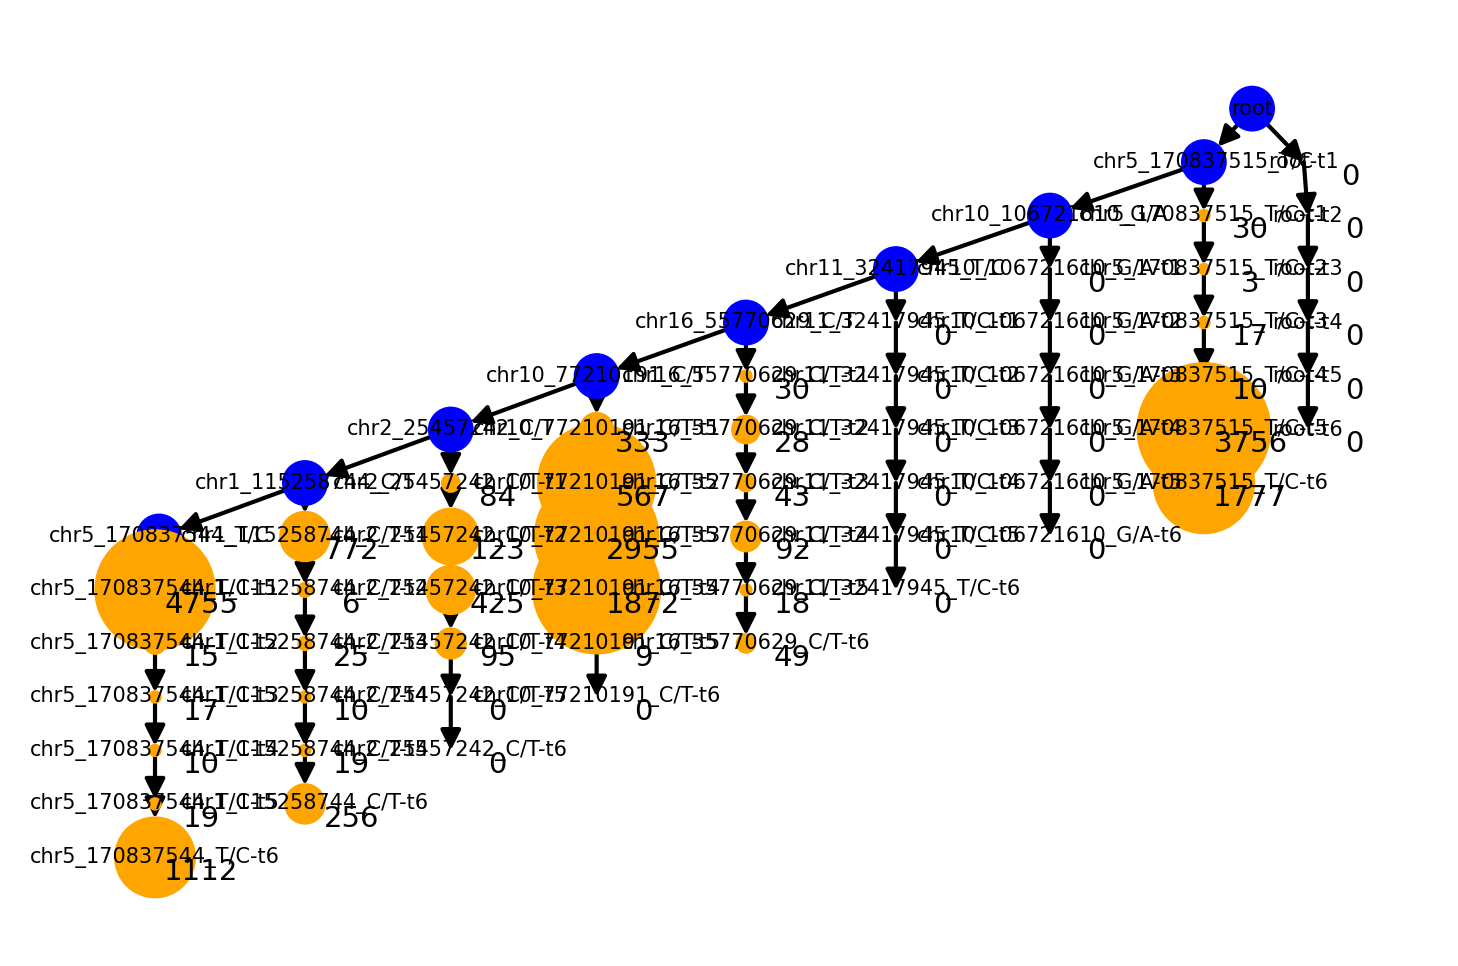

1157958.2096435402


array([[1, 1, 1, ..., 1, 1, 1],
       [0, 0, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [0, 0, 1, ..., 0, 0, 0]])

In [406]:
analyze_Phyllochron_results("AML-97", 6)